David Fleming Oct. 2015

This notebook is used to make movies of how disk parameters evolve with time.  Specifically, heatmaps of all the disk particles are made with respect to certain parameters of the gas particles, such as their longitude of perihelion vs. semimajor axis and so on.  These movies allow us to see how resonances form and precess in the inner disk and at what timescale.

In [2]:
%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Tell code where my diskpy distribution is
import os
sys.path.append('/astro/users/dflemin3/Desktop/diskpy')
sys.path.append('/astro/users/dflemin3/Desktop')

#Import diskpy and my modules from ICgen submodule
import diskpy
from diskpy.ICgen import *
from diskplot import *

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

# Tell the code where the data is

In [3]:
cwd = '/astro/users/dflemin3/Desktop/sims/k38EccBigGap'
os.chdir(cwd)

# Read parameters from the .param file to determine timesteping, etc

In [4]:
#Read in .param file and extract info I need

name = ''
length = 0
dDelta = 0.0

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    for line in lines:
        line = str(line).rstrip('\n')

        #.param files are of the form: tParamName = val
        
        #Look for file name
        if "achOutName" in line:
             name = line.split()[-1]

        #Look for iOutInterval
        if "iOutInterval" in line:
            outInt = int(line.split()[-1])

        #Look for number of steps
        if "nSteps" in line:
            nSteps = int(line.split()[-1])

        #Look for dDelta
        if "dDelta" in line:
            dDelta = float(line.split()[-1])
            
#Compute important quantities
length = nSteps/outInt
dt = dDelta/(2.0*np.pi) #Years per step

# Compute binary parameters to allow for relative comparisons between binary and disk particles.

In [6]:
#Calculate system parameters
s = pynbody.load(name + ".std")

x1, x2 = s.stars['pos']
m1, m2 = s.stars[0]['mass'], s.stars[1]['mass']
v1, v2 = s.stars['vel']
m_disk = np.sum(s.gas['mass'])
x = x1-x2
v = v1-v2
X = [x,v]
test = binary.Binary(X,m1,m2,'cartesian')

Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.std
TipsySnap: loading data from main file
/astro/users/dflemin3/Desktop/diskpy/diskpy/ICgen/AddBinary.py:513: RuntimeWarning: invalid value encountered in divide
  Omega = np.arccos(dotProduct(i, n) / magN)


# Make the movie!
Can edit below to specify parameters you want to plot, although it's typically most useful to have the x-axis be gas particles argument of perihelion + longitude of ascending node relative to the binary's for precession purposes.

Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000068
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000136
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000204
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000272
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000340
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.000408
TipsySnap: loading data from main file
SimSnap: deriving array rxy
Loading using backend <class 'pynbody.tipsy.Ti

ERROR! Session/line number was not unique in database. History logging moved to new session 1565


 rxy


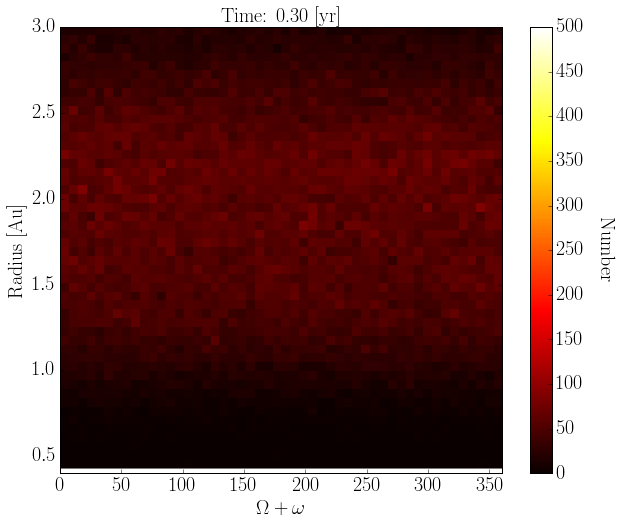

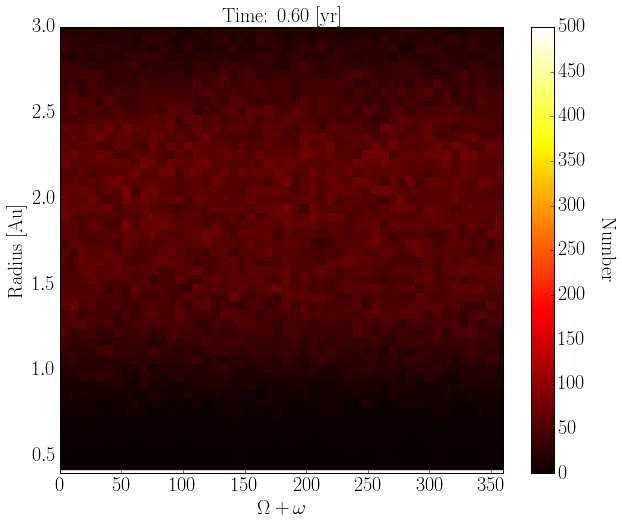

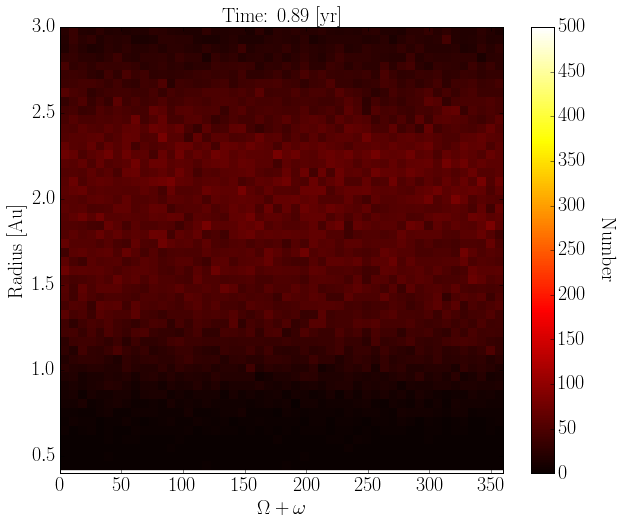

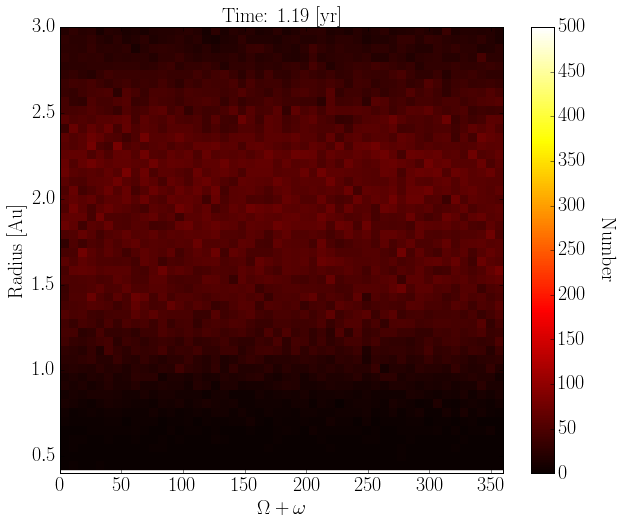

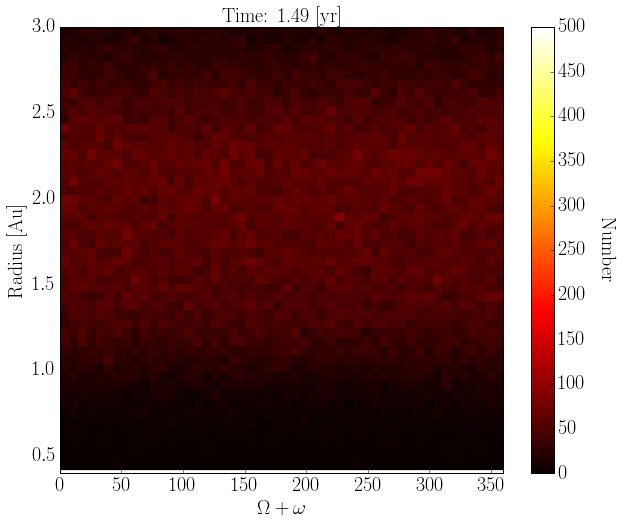

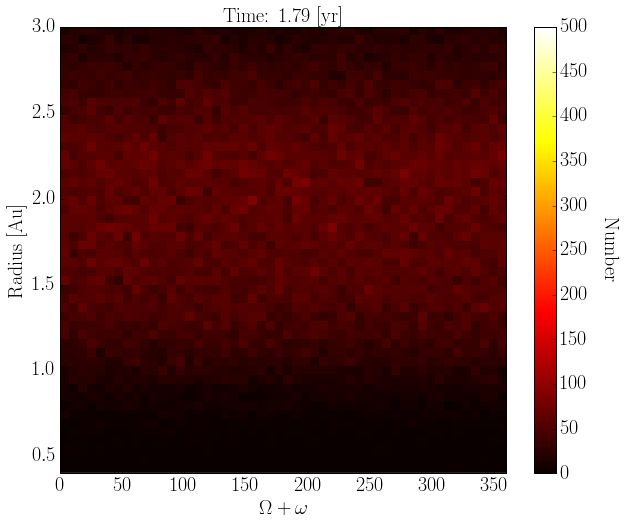

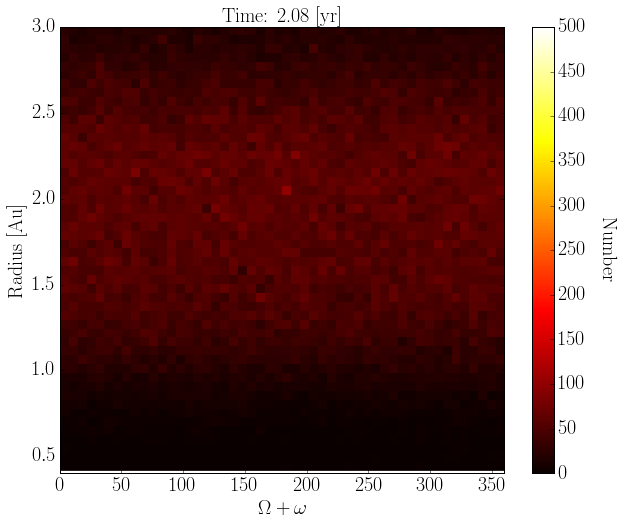

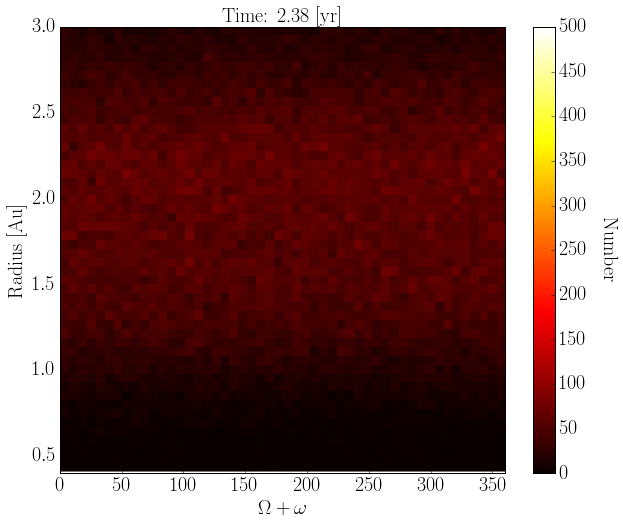

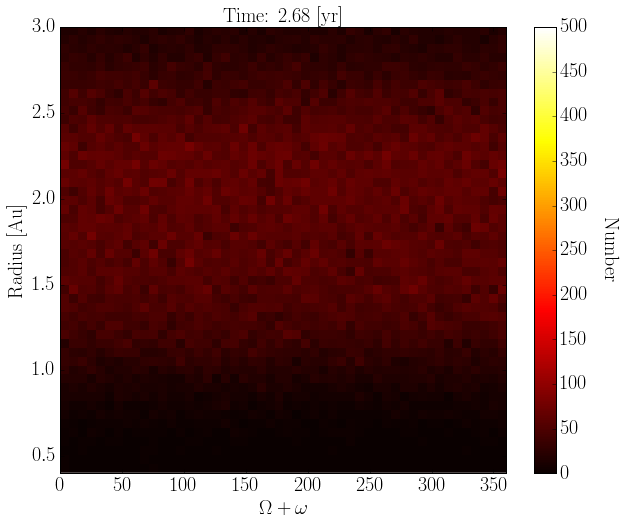

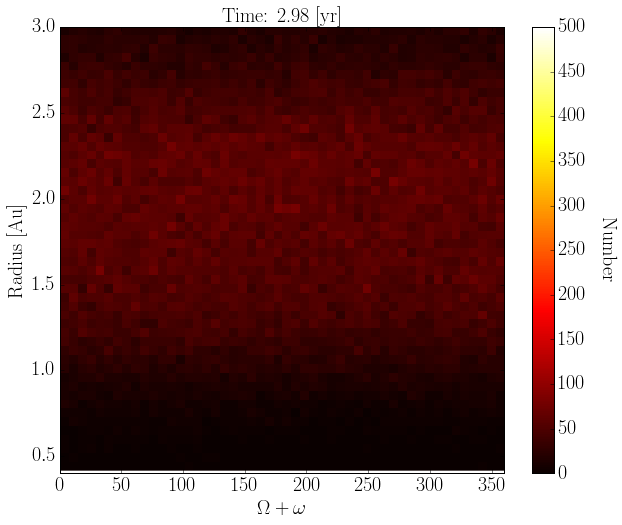

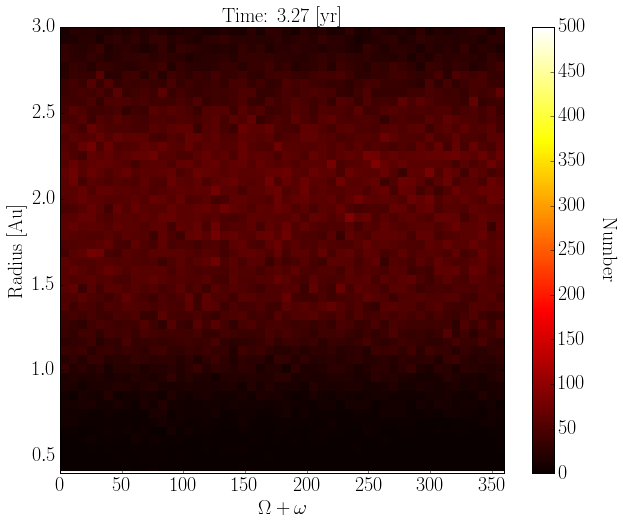

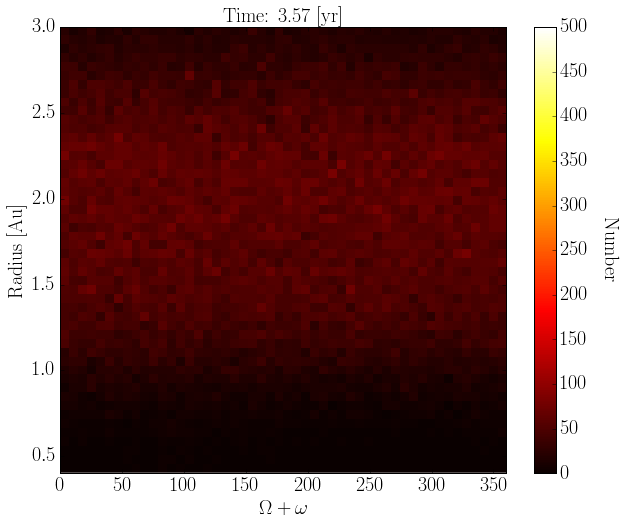

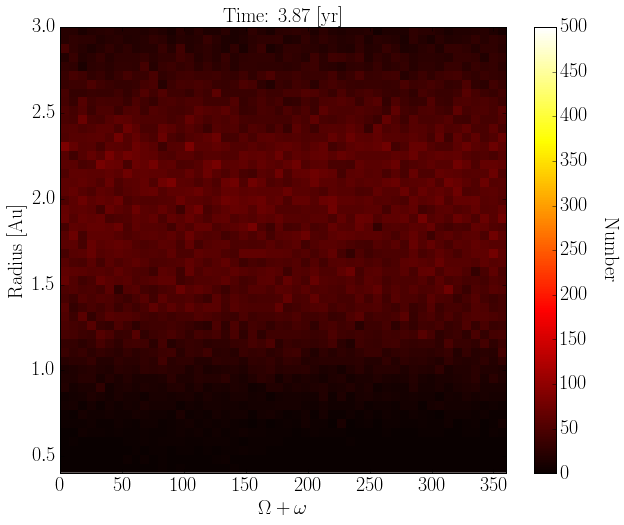

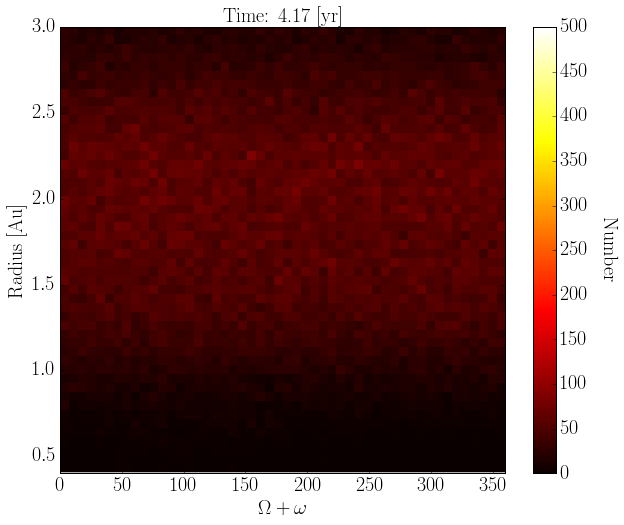

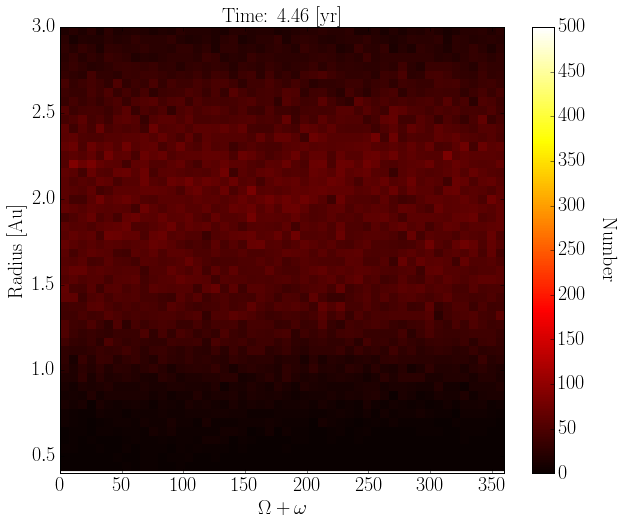

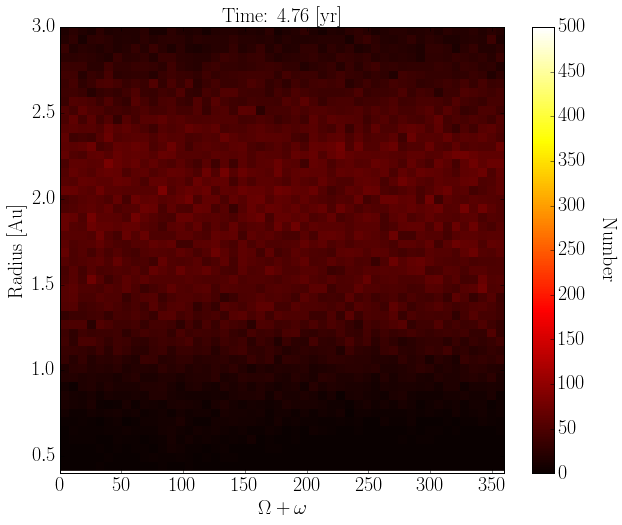

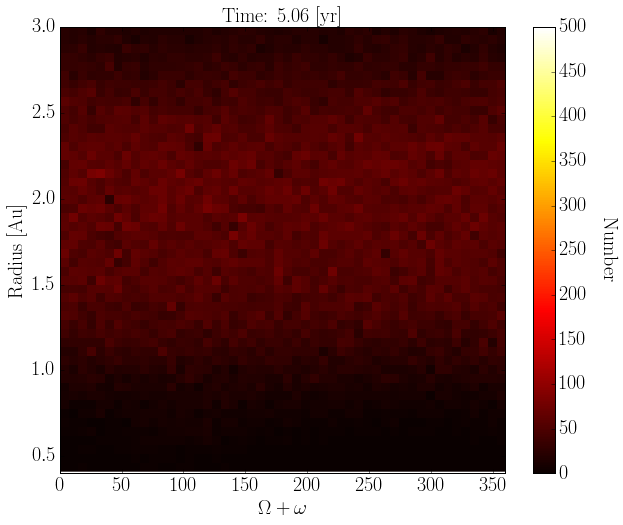

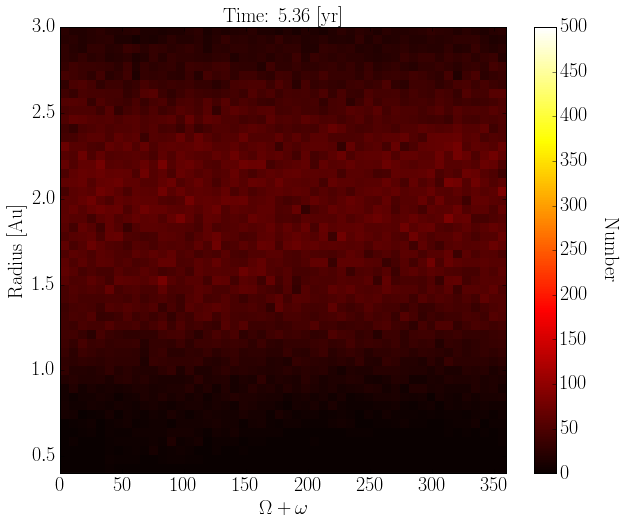

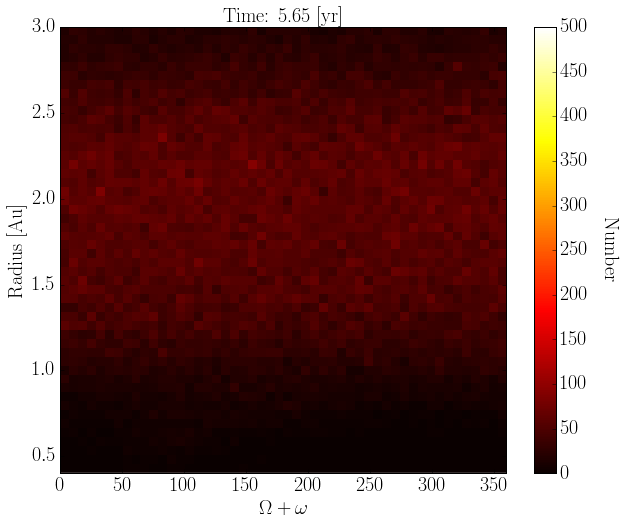

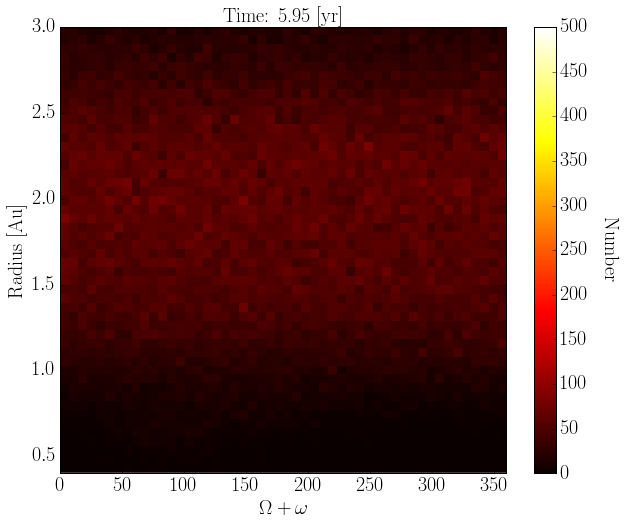

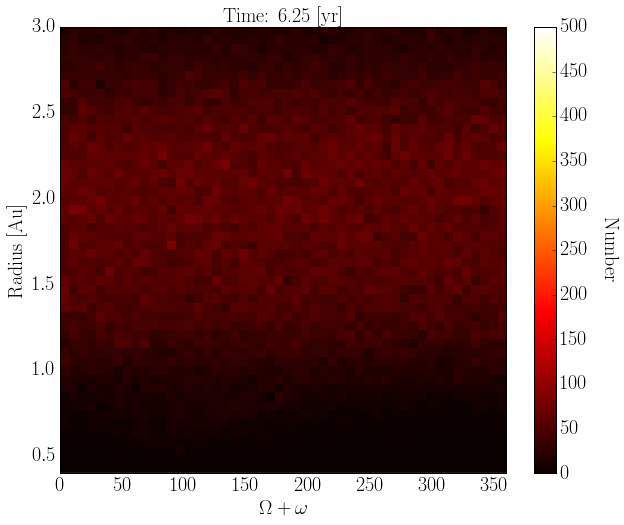

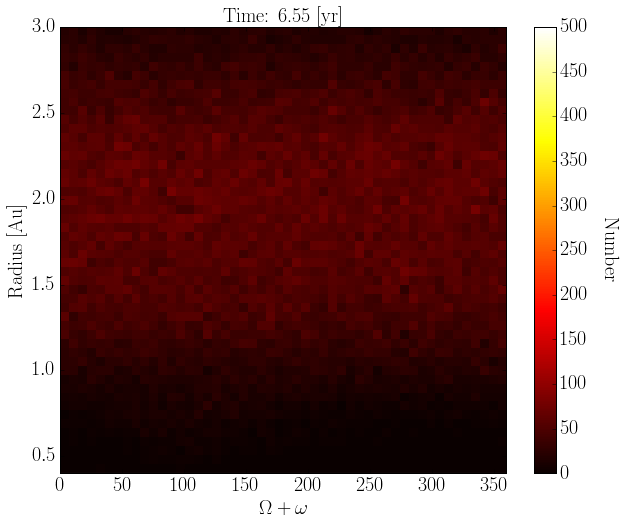

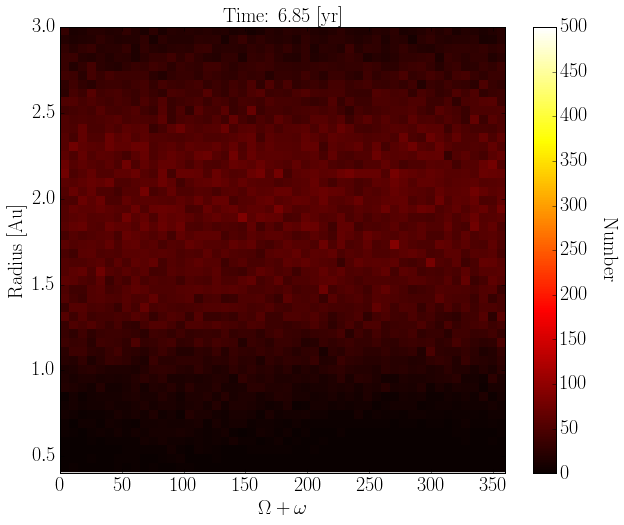

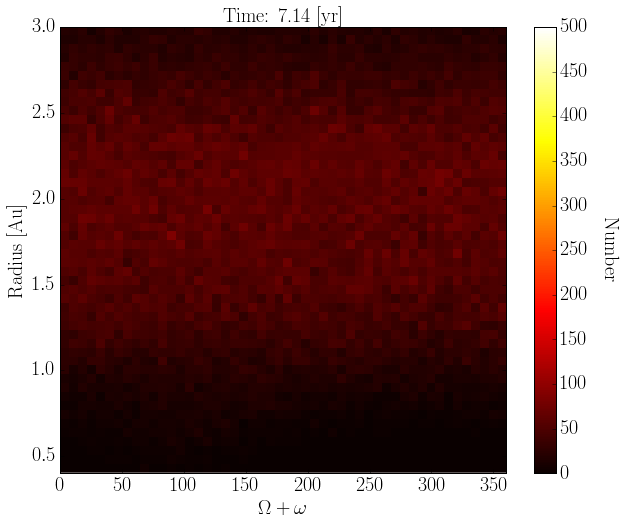

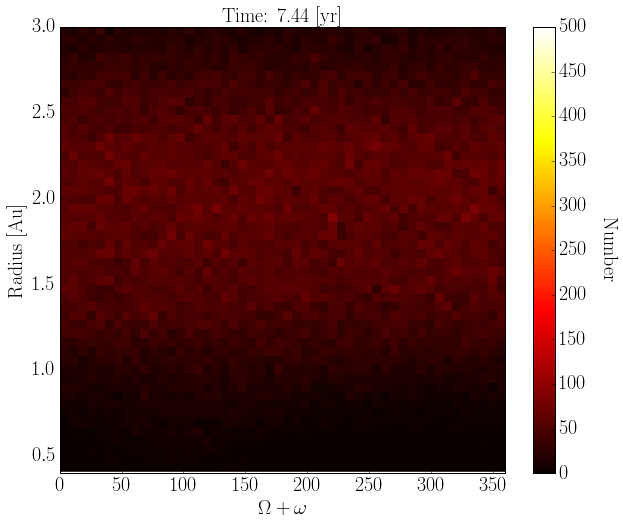

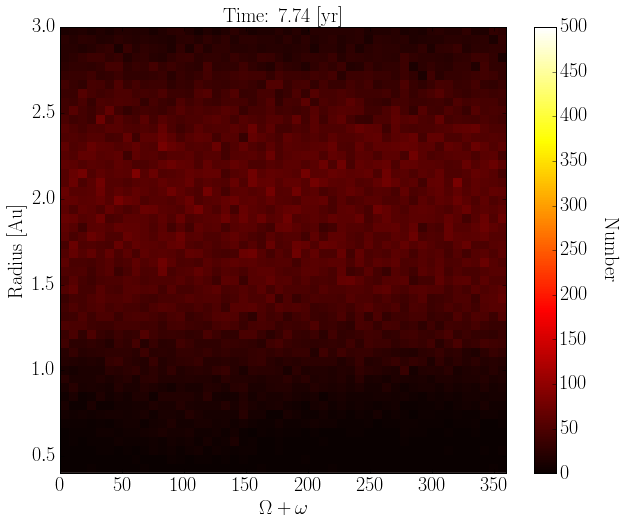

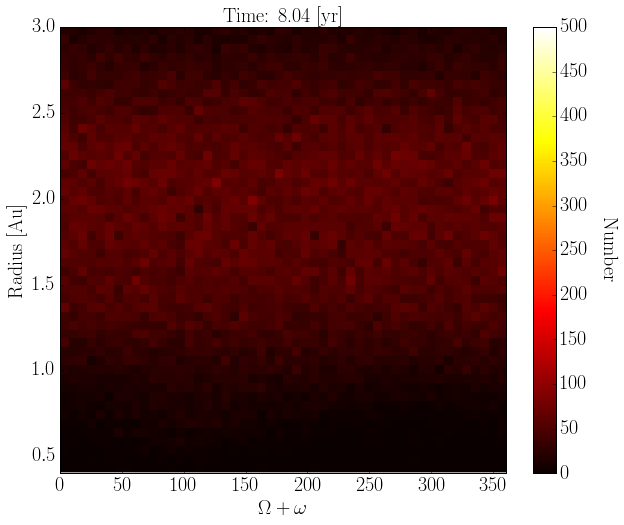

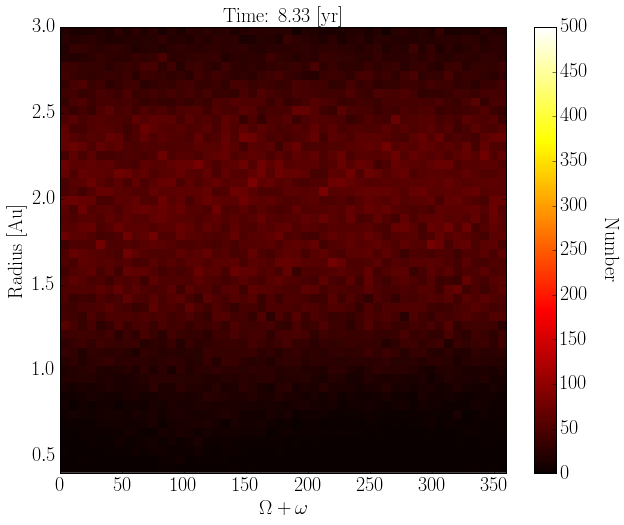

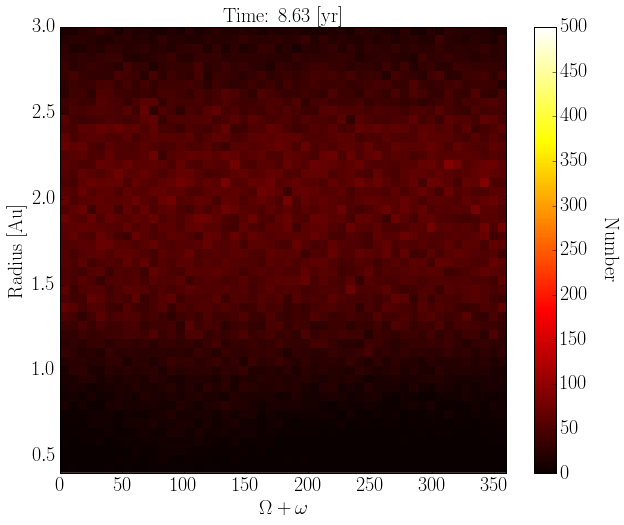

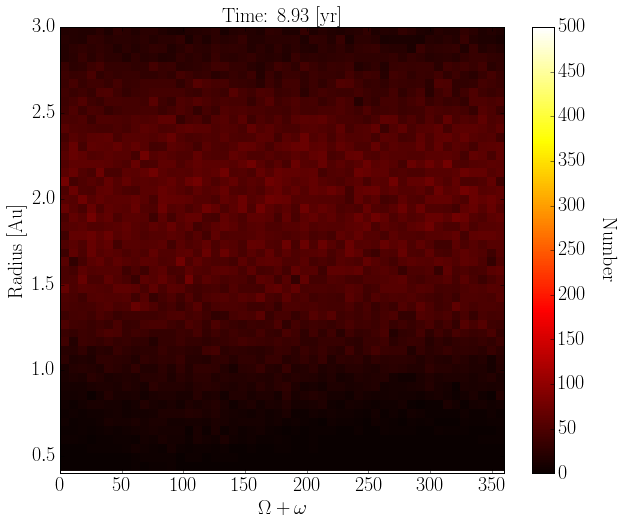

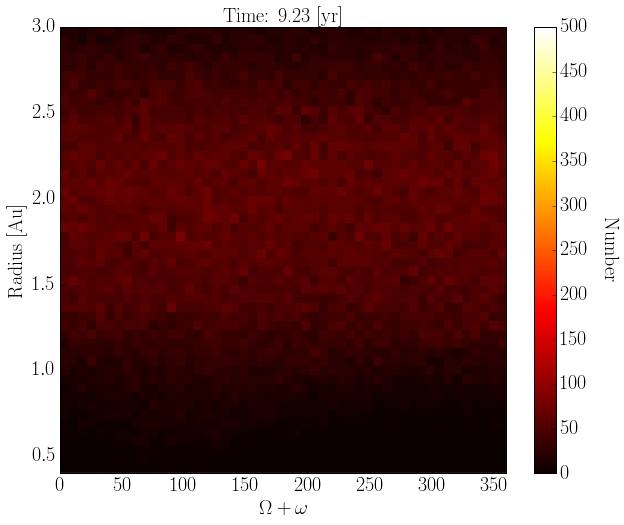

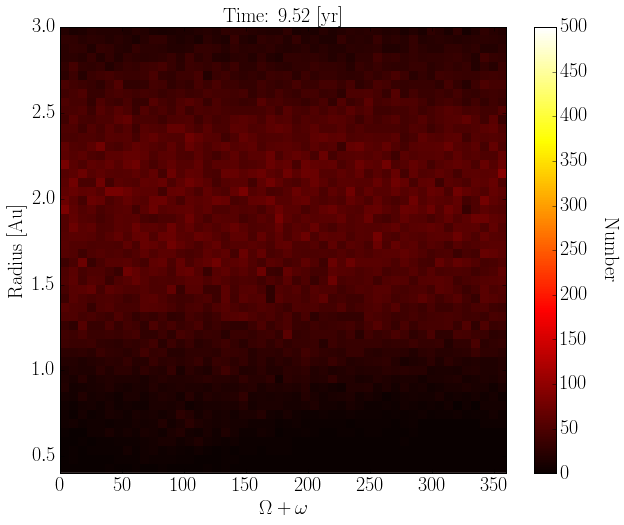

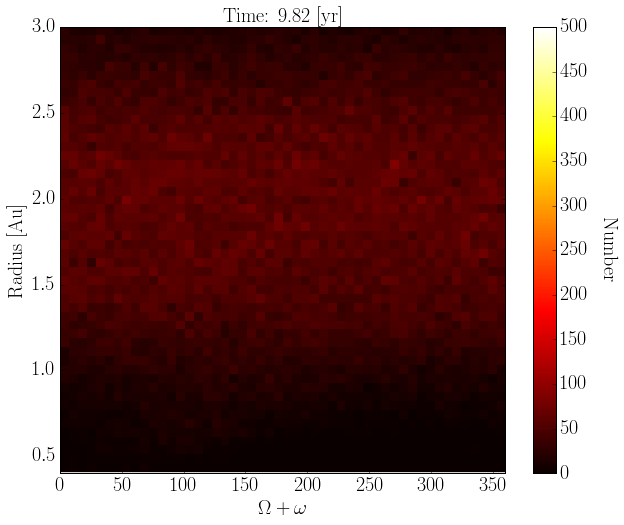

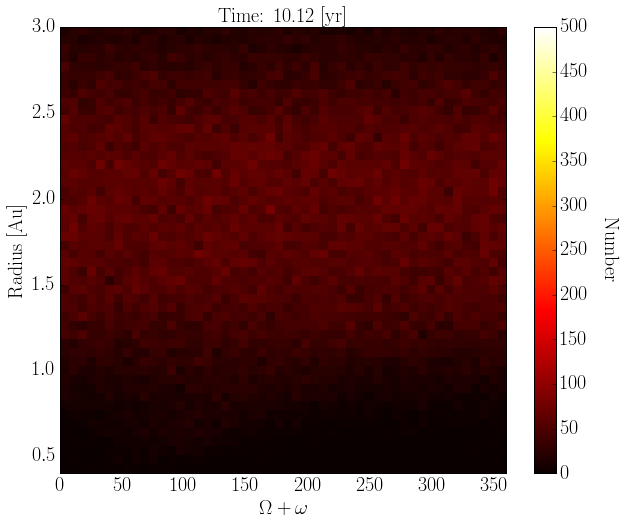

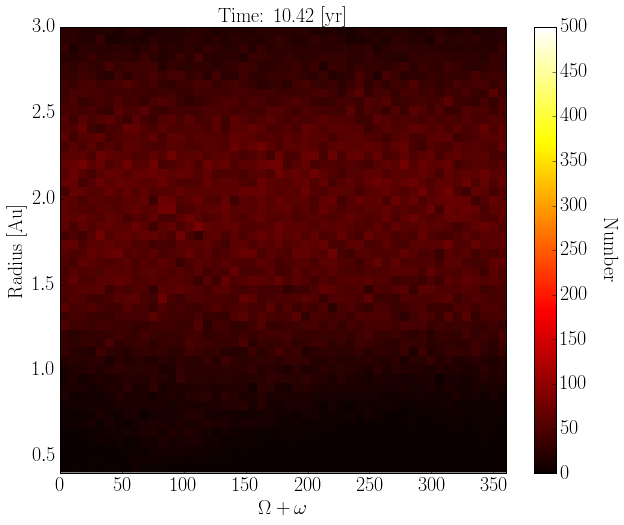

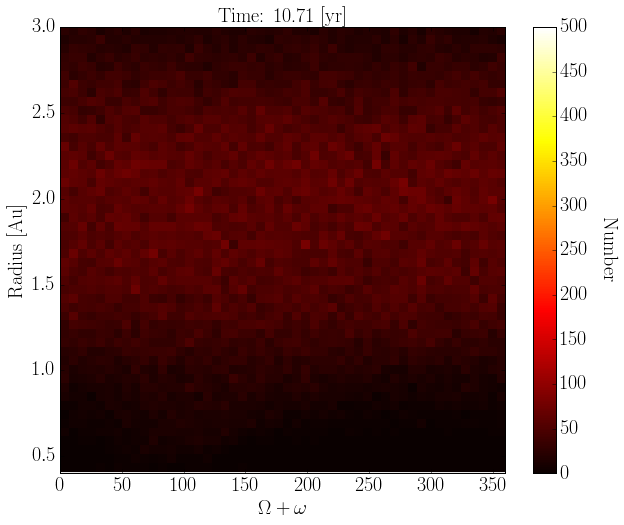

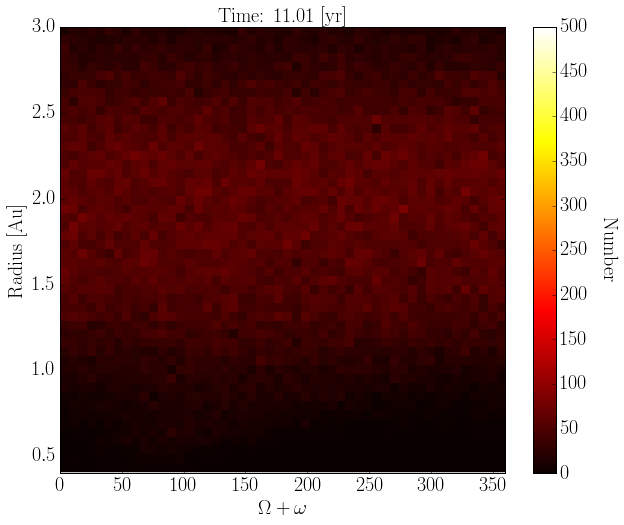

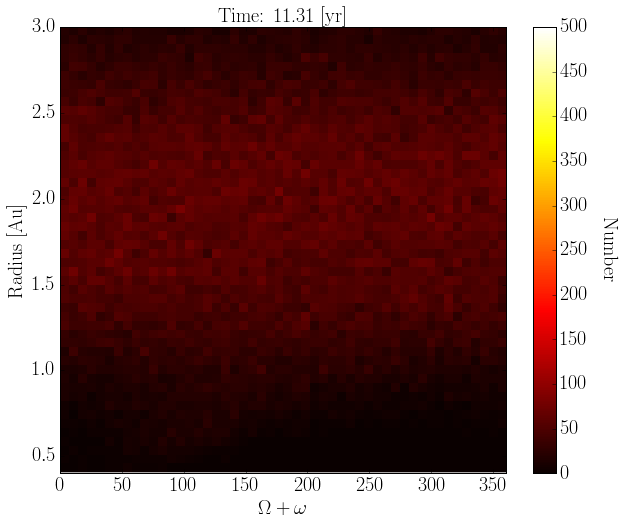

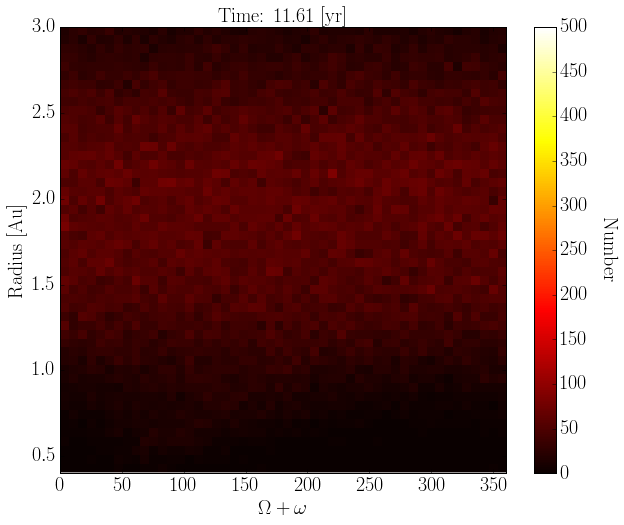

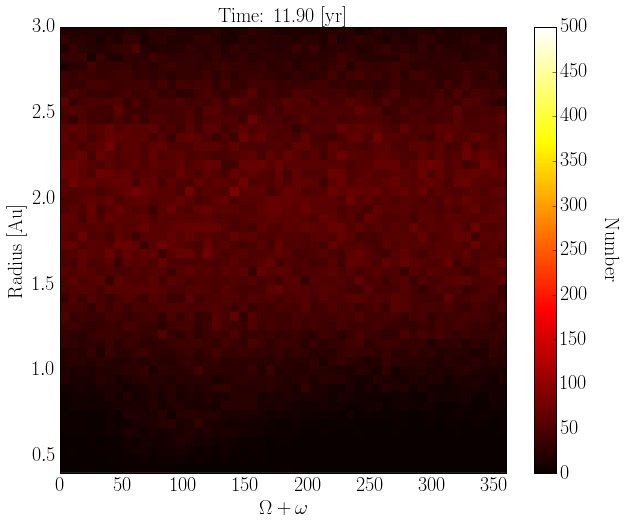

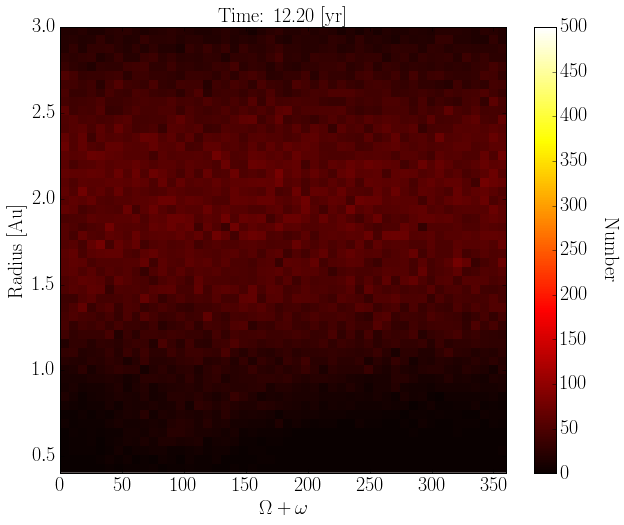

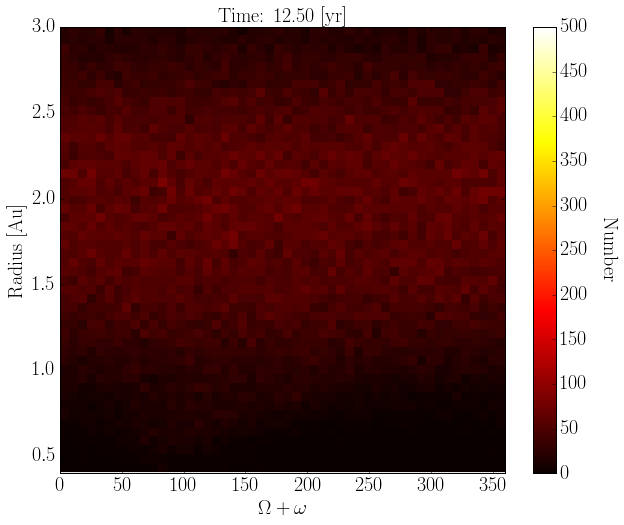

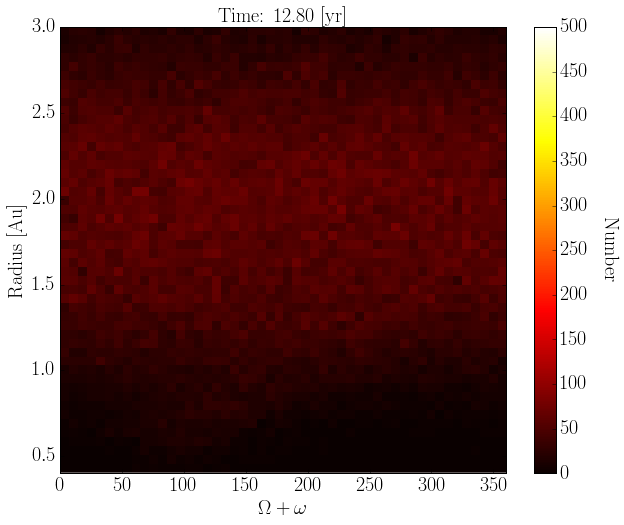

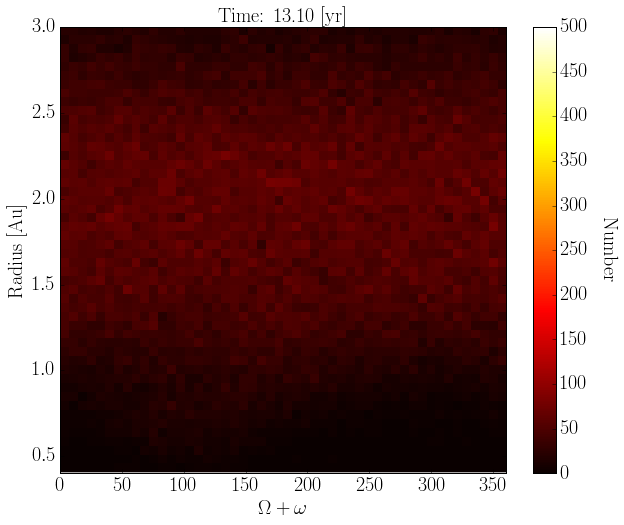

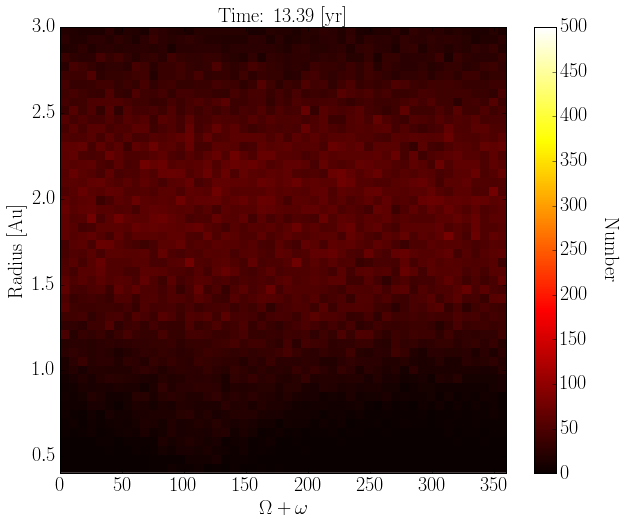

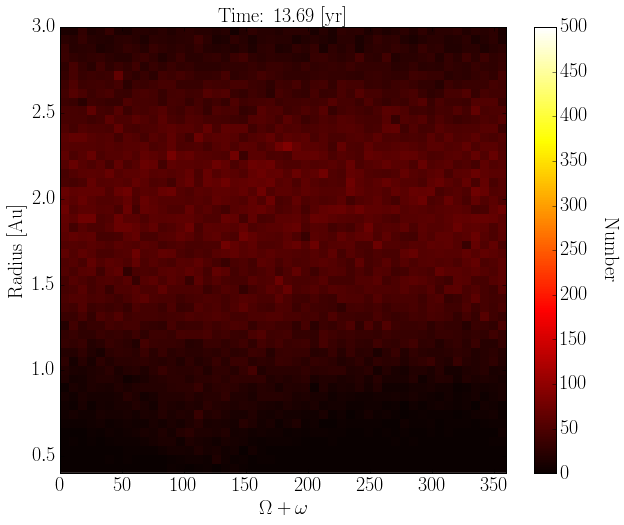

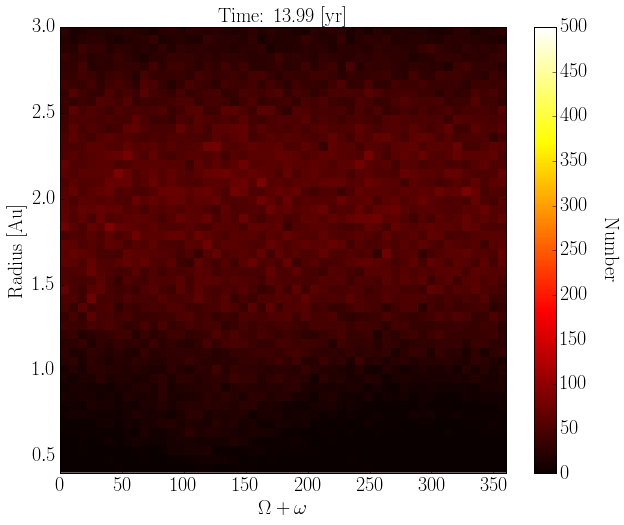

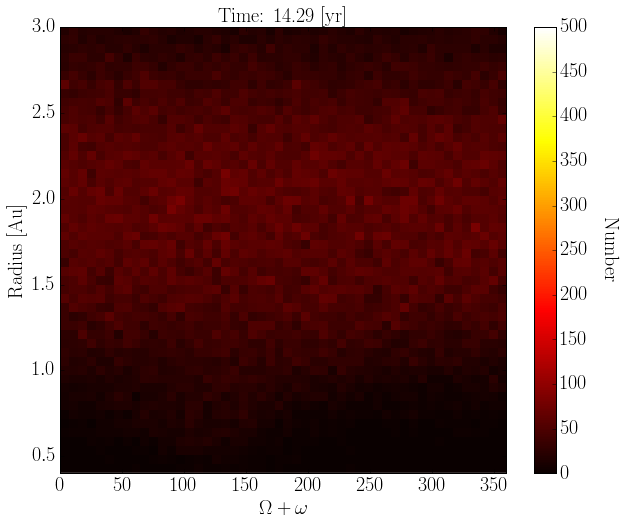

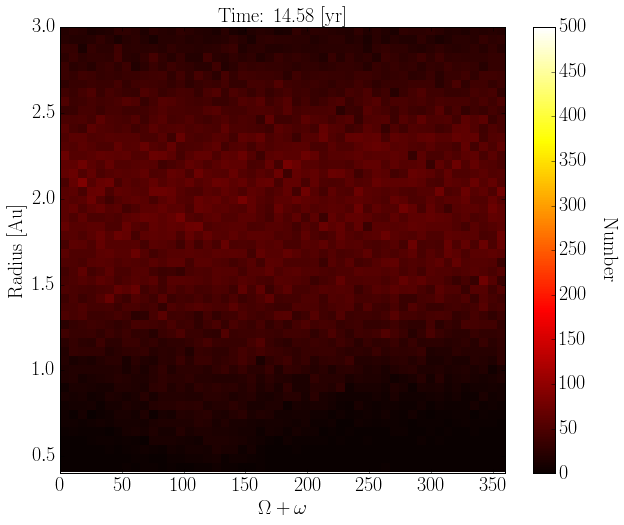

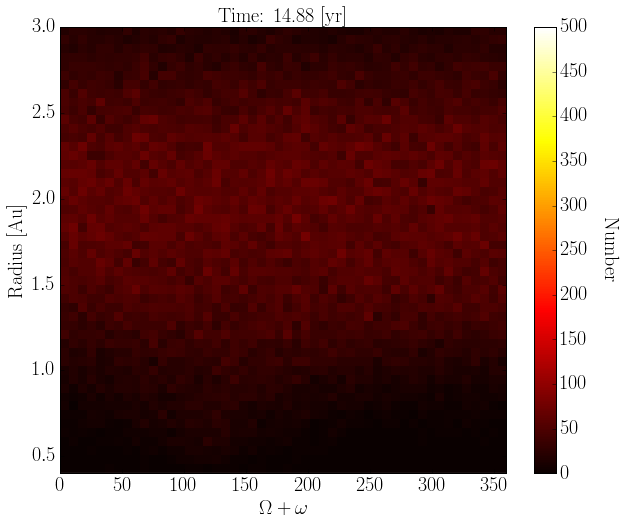

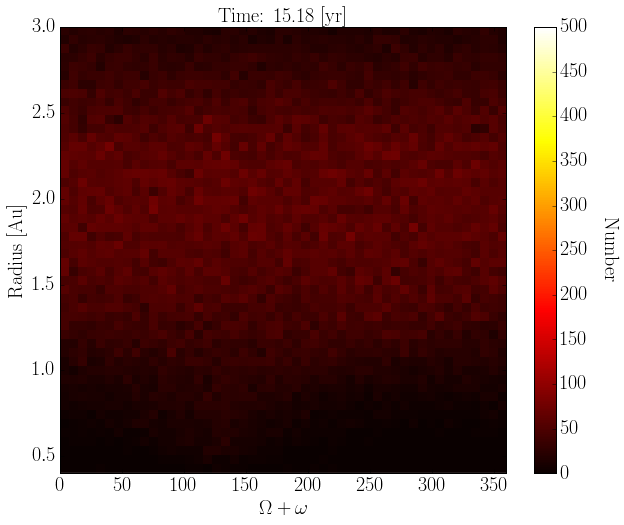

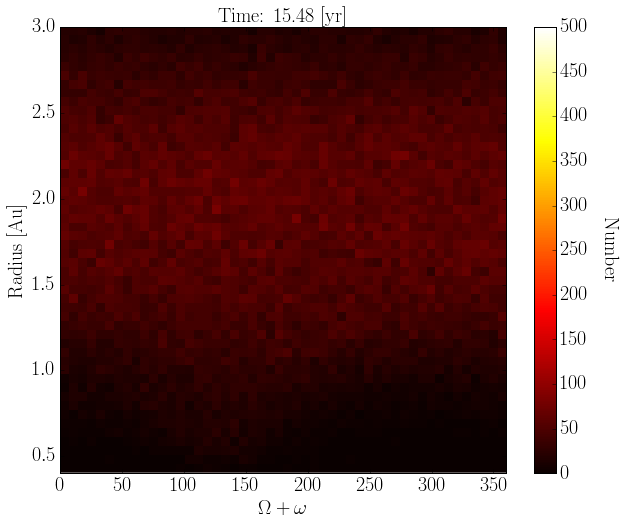

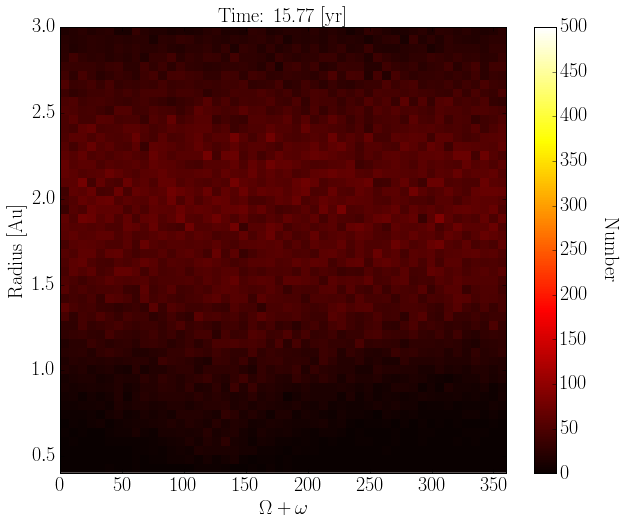

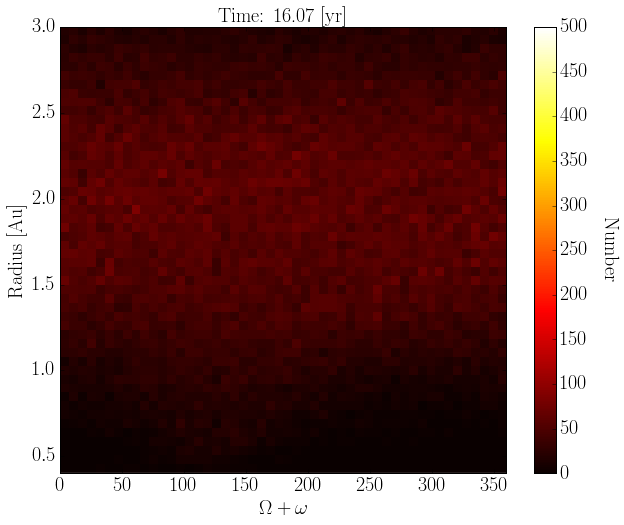

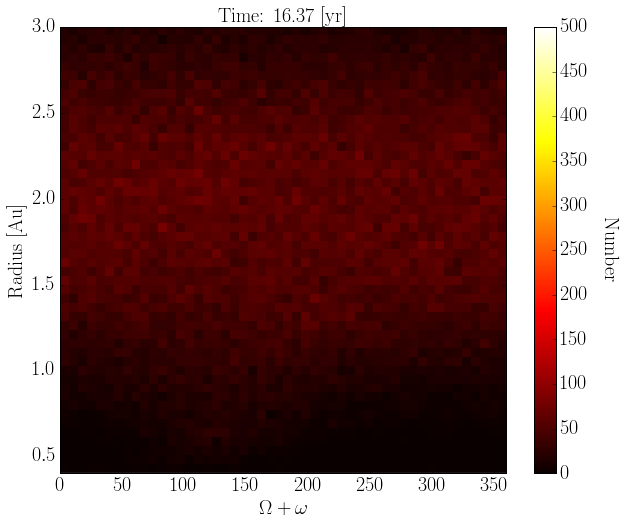

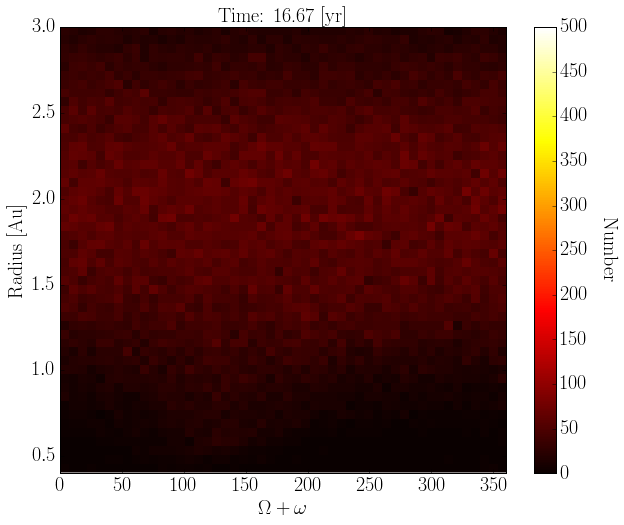

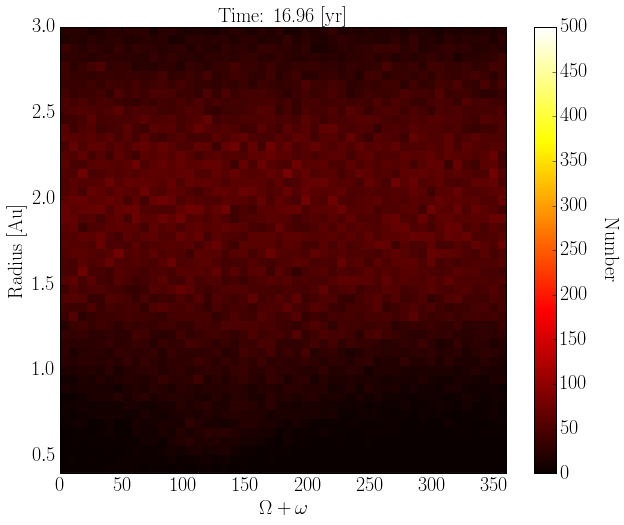

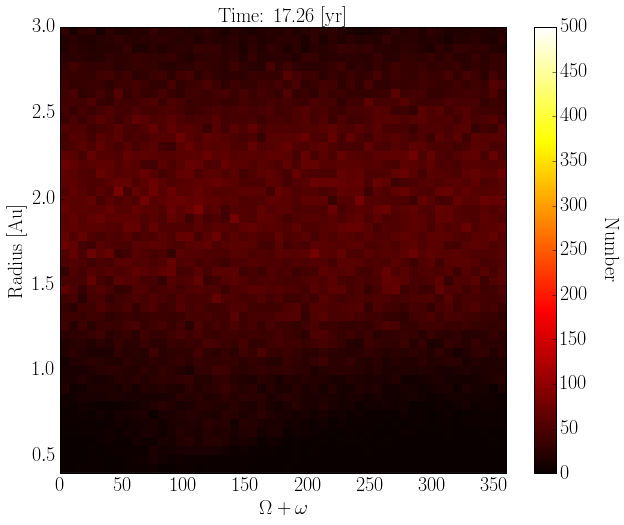

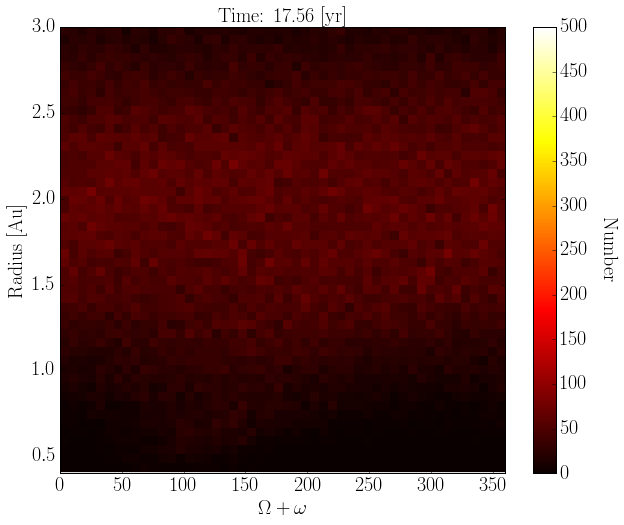

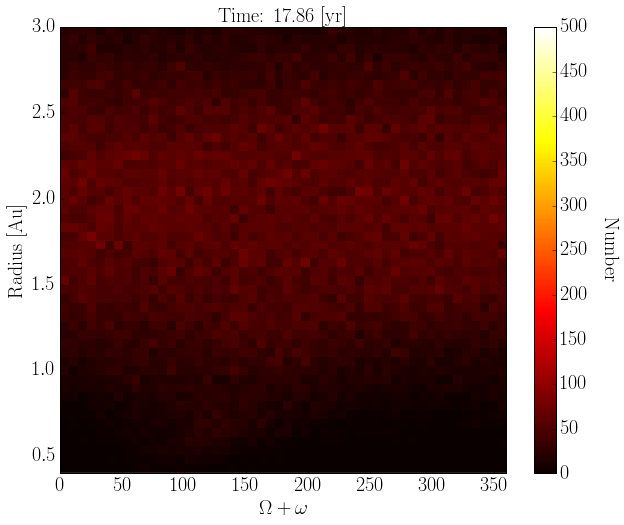

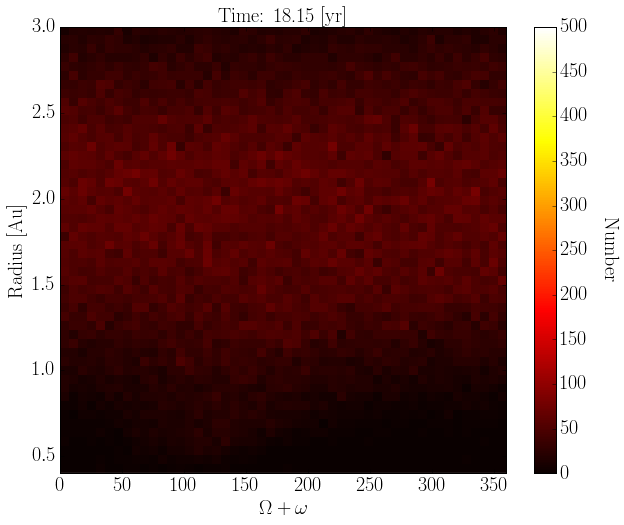

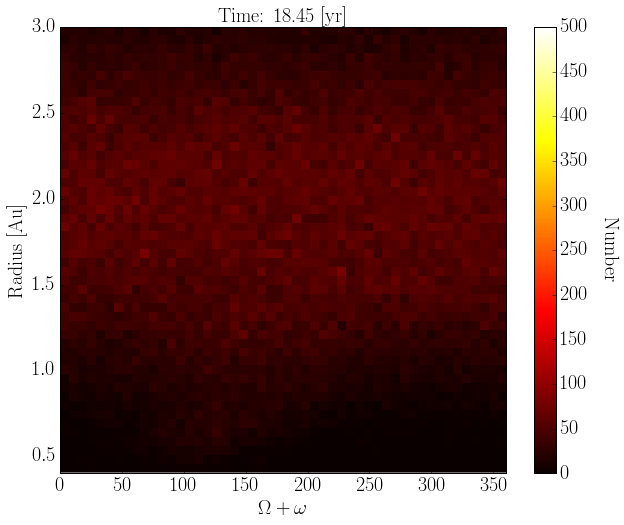

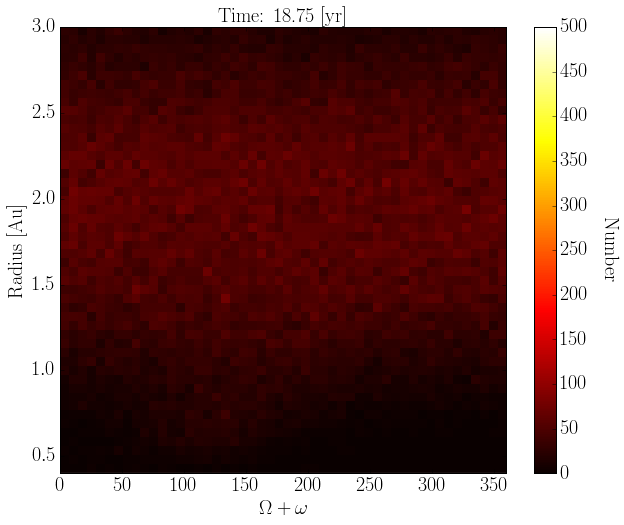

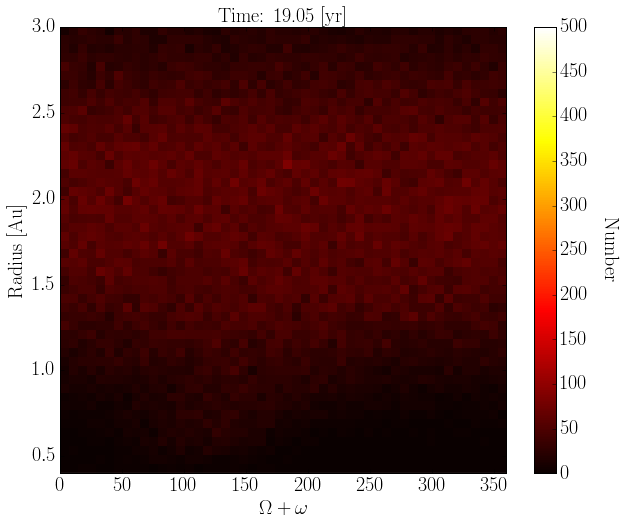

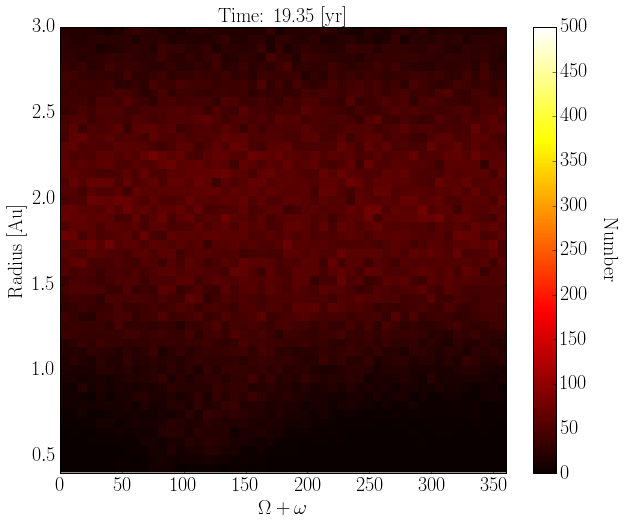

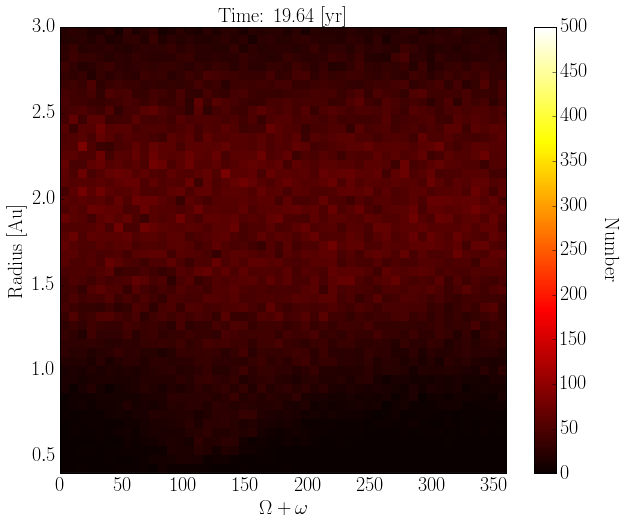

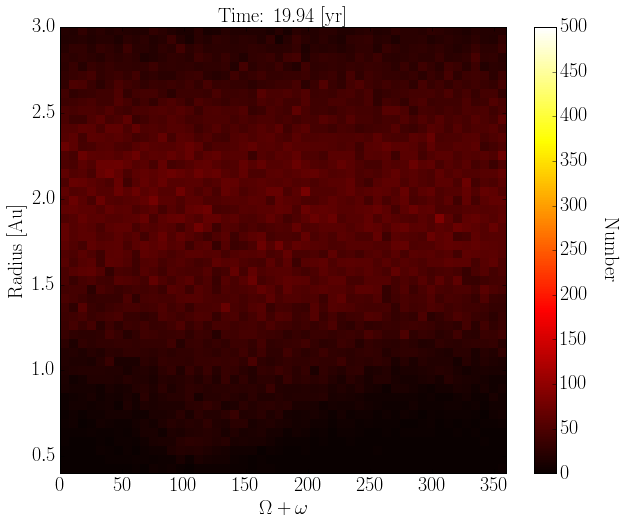

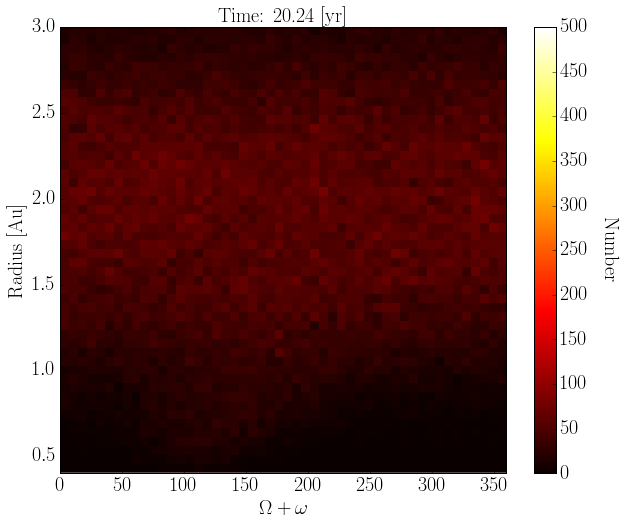

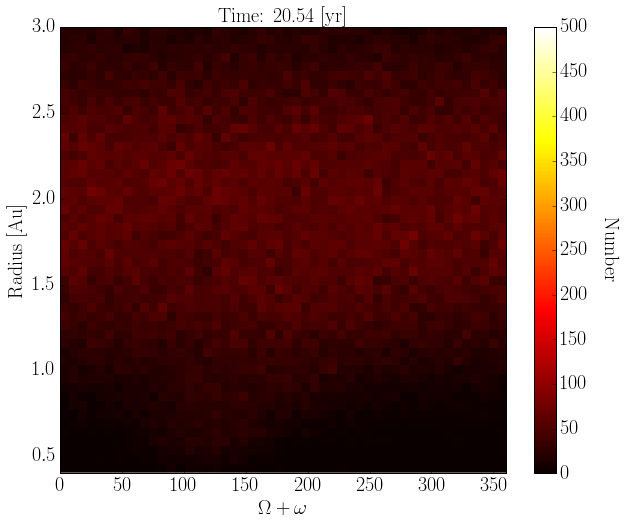

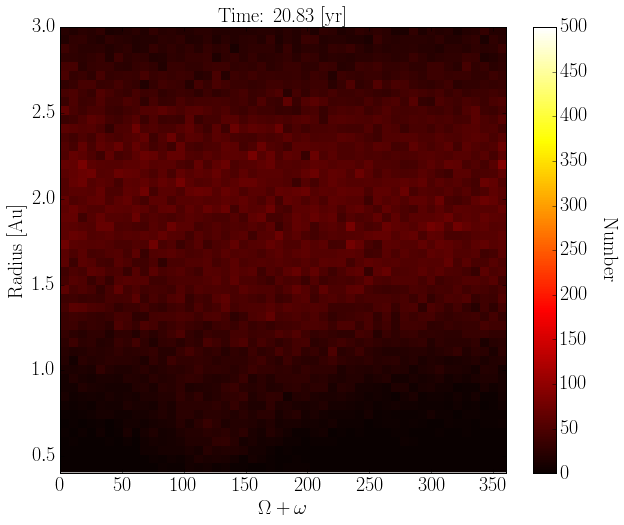

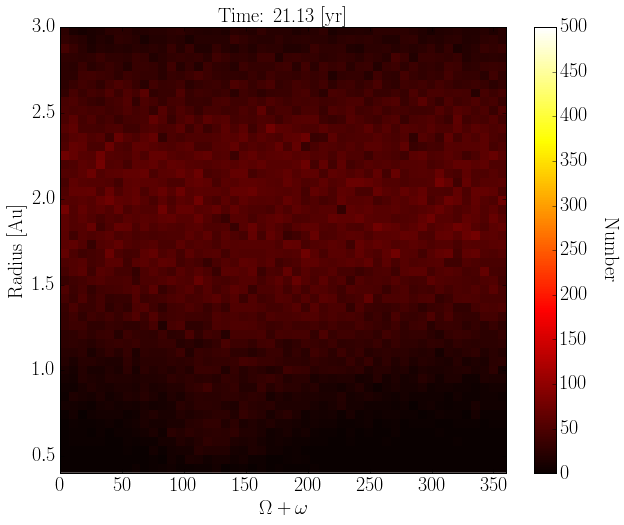

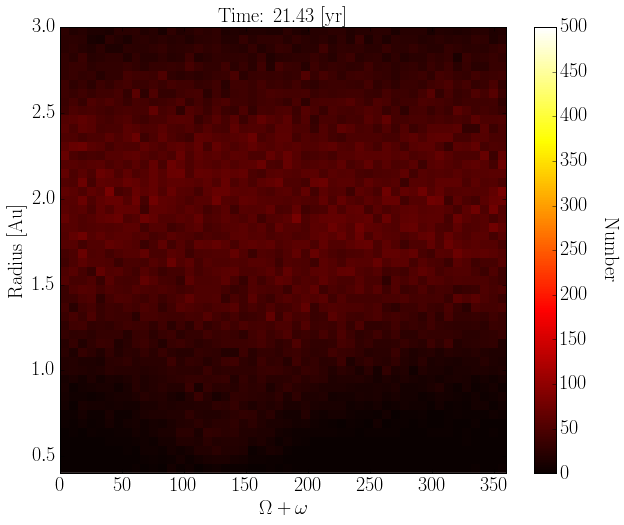

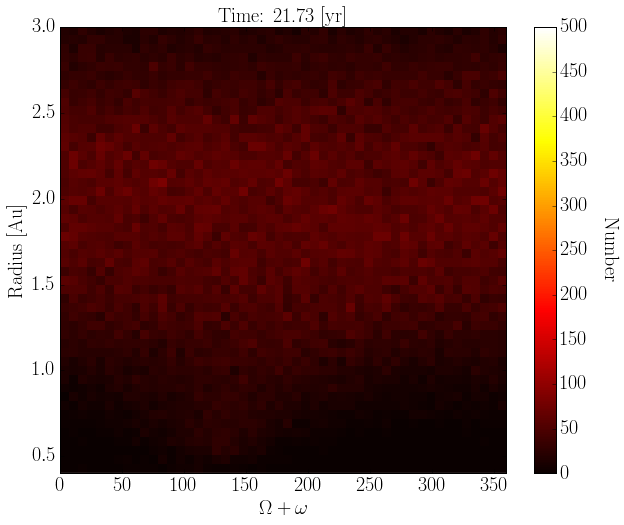

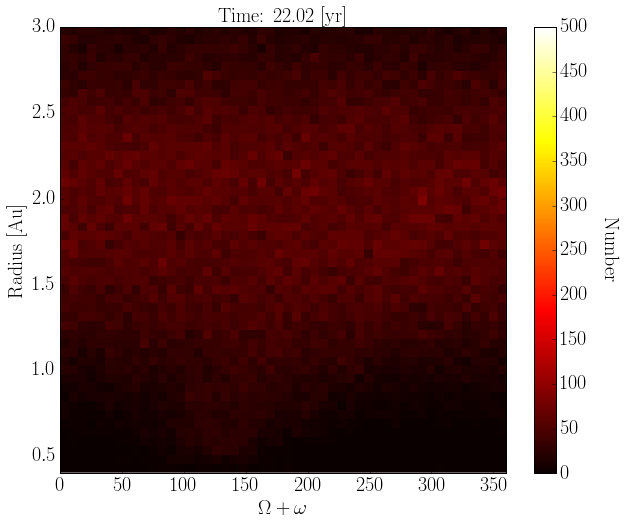

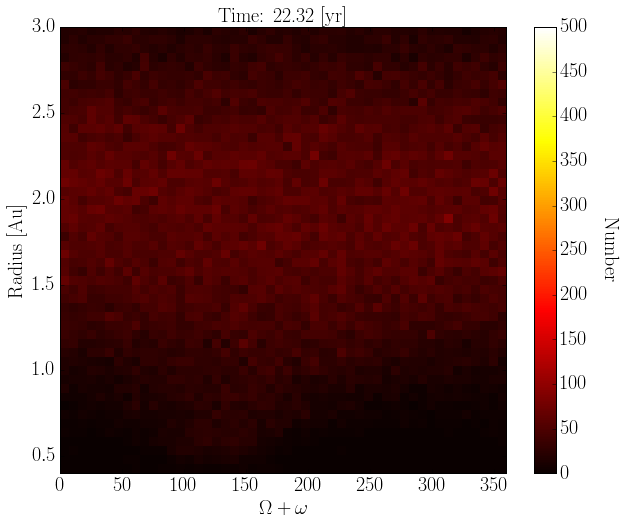

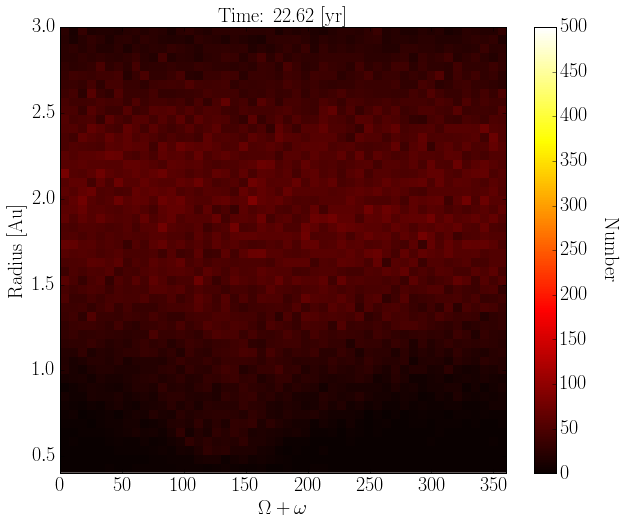

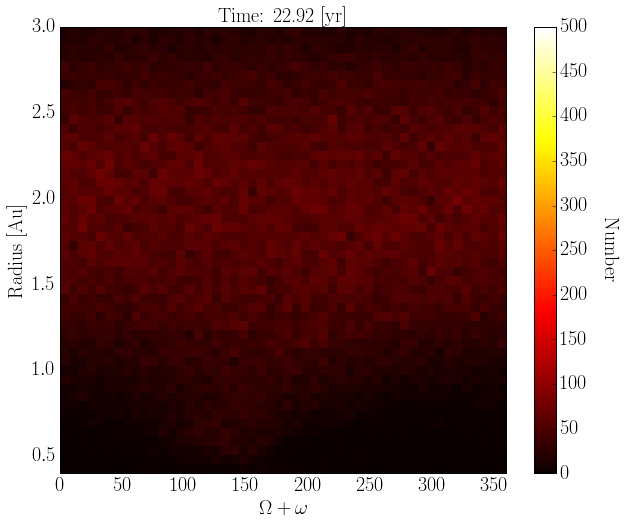

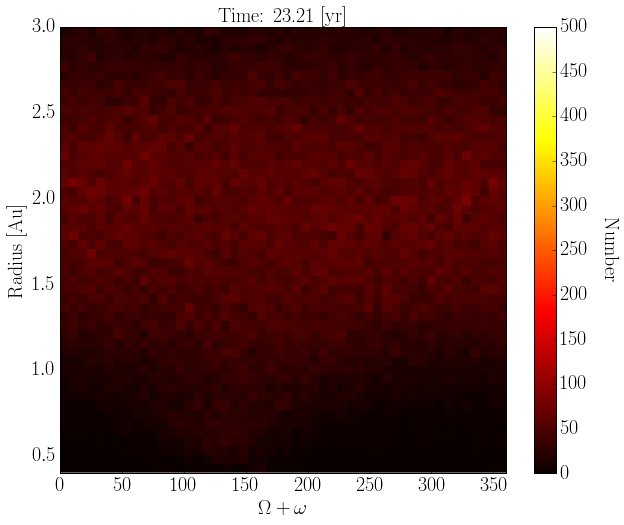

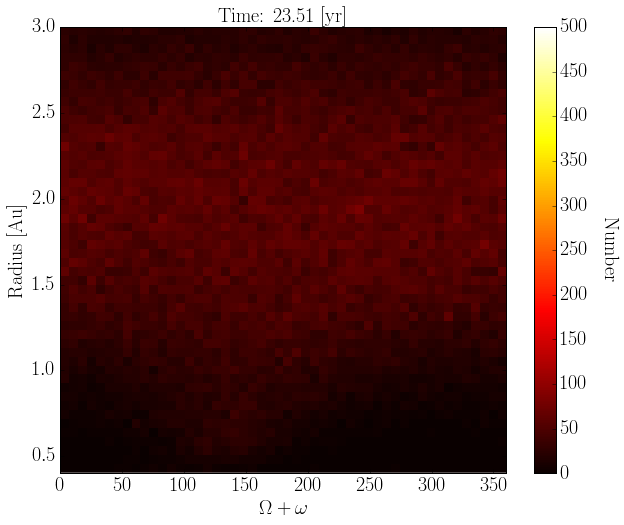

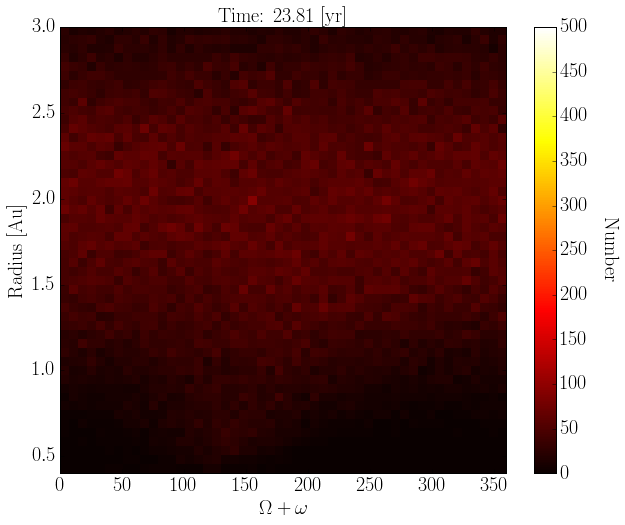

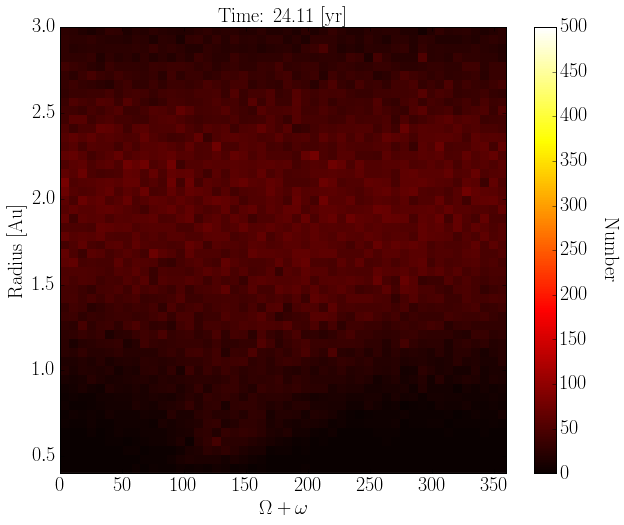

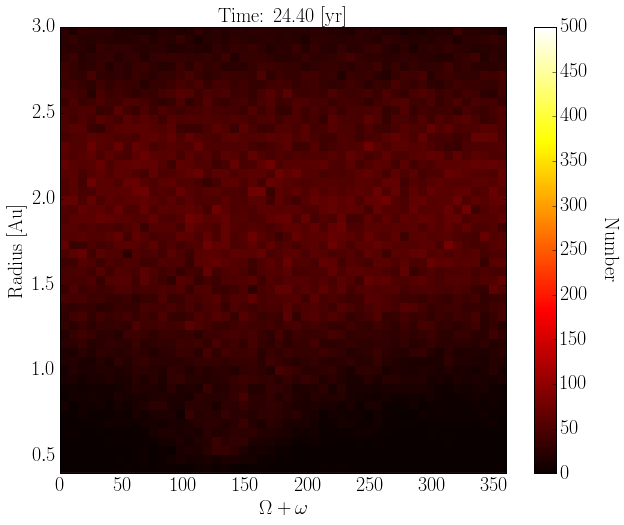

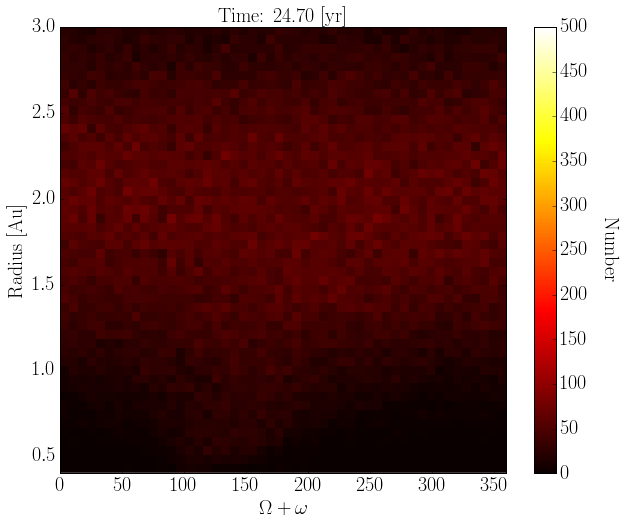

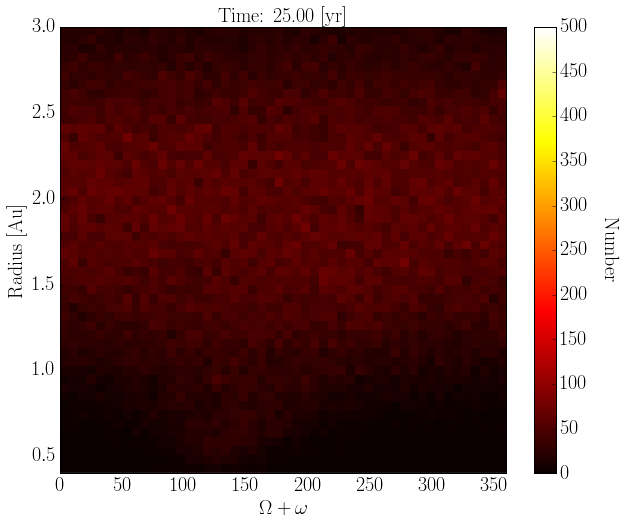

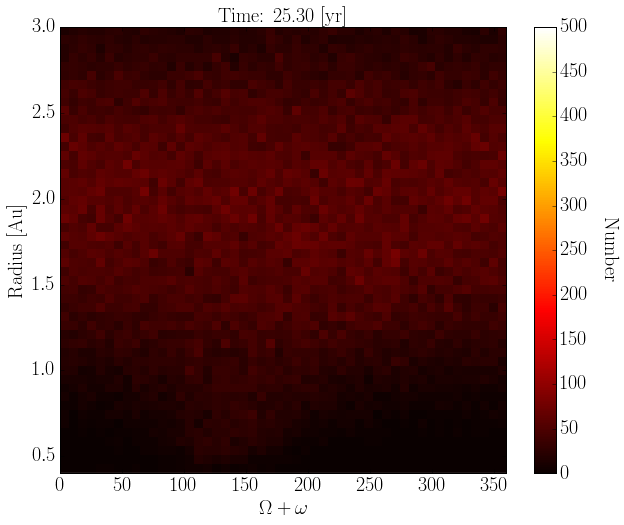

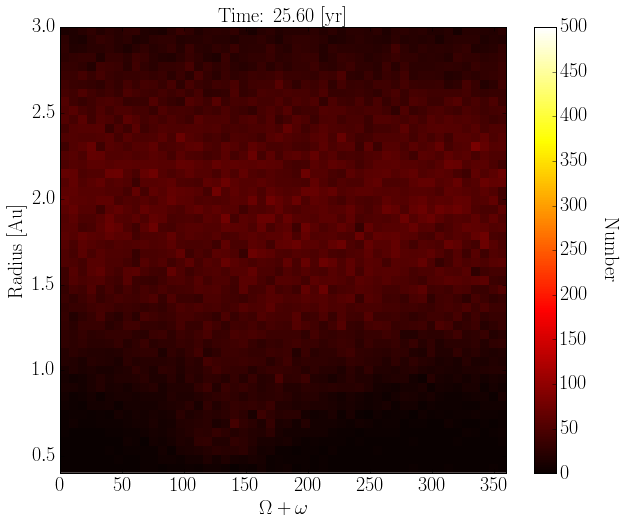

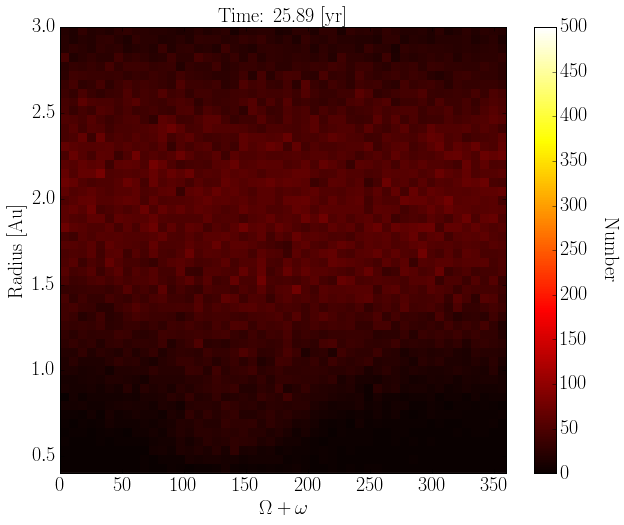

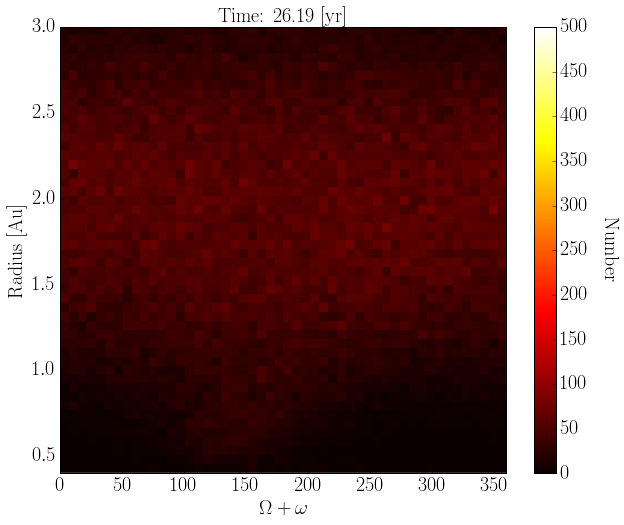

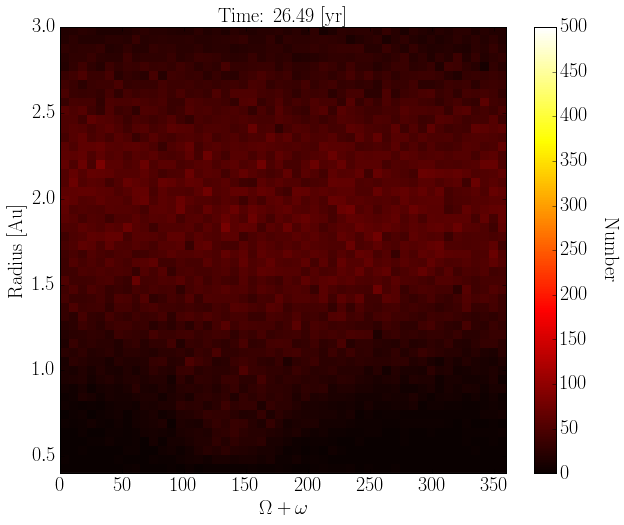

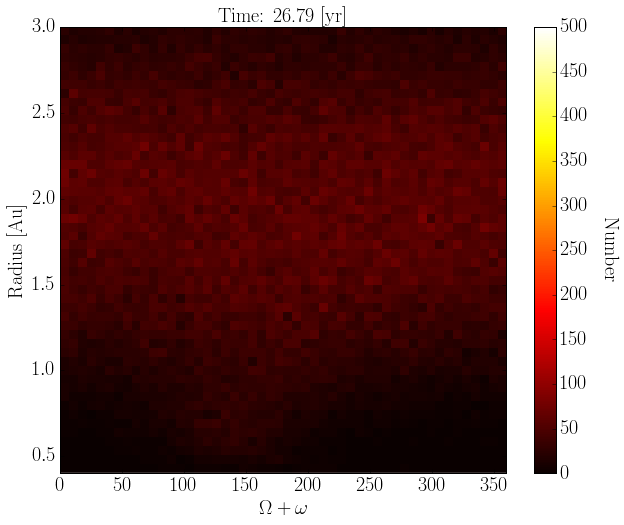

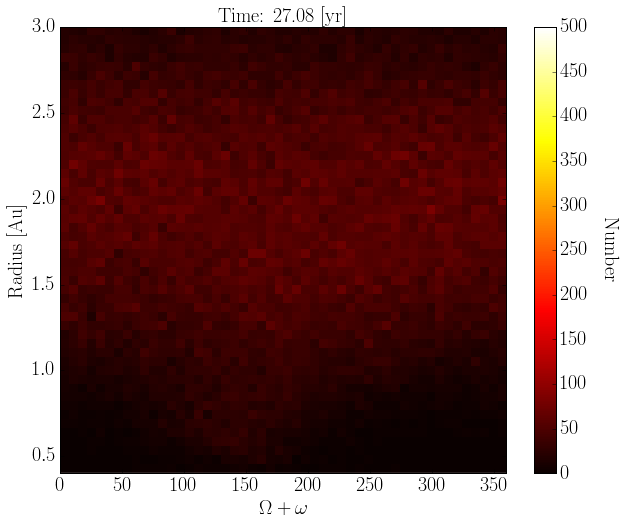

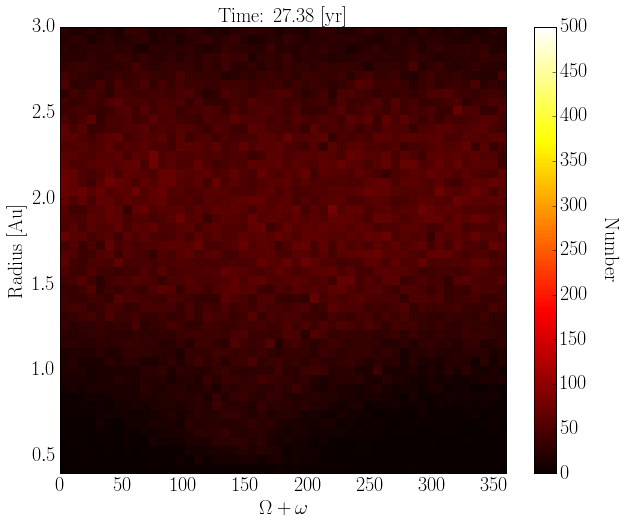

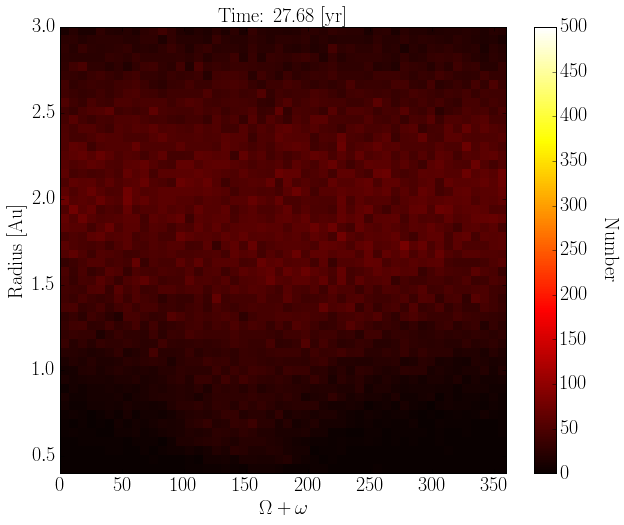

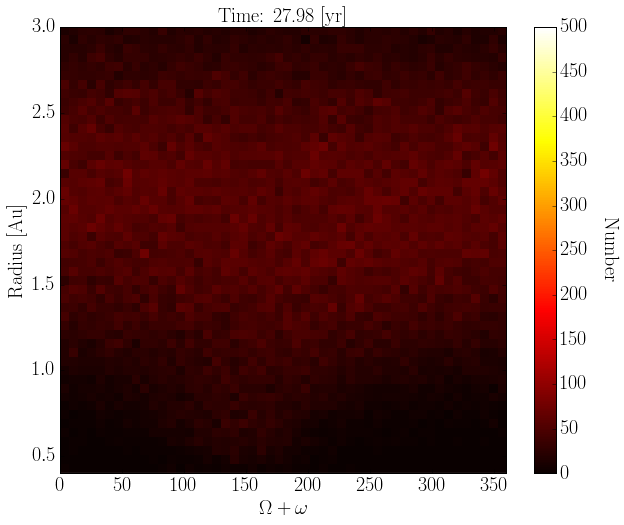

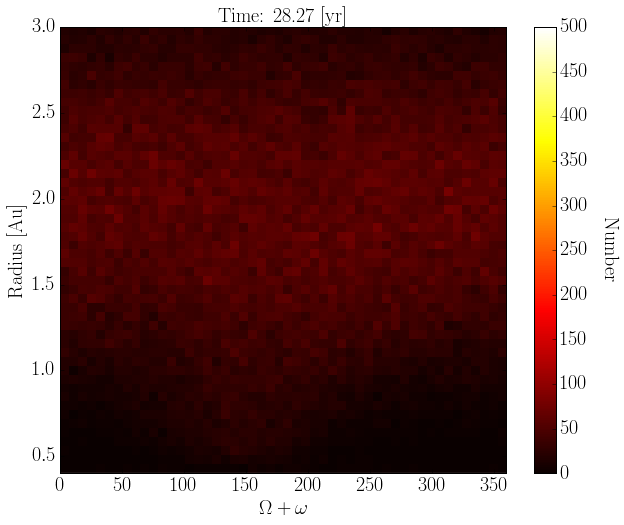

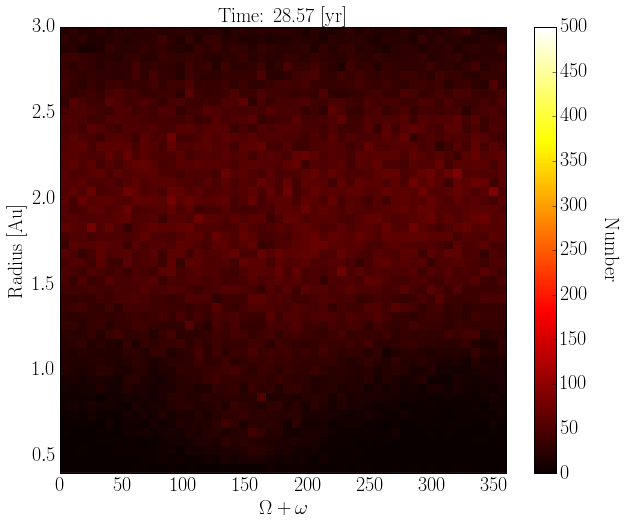

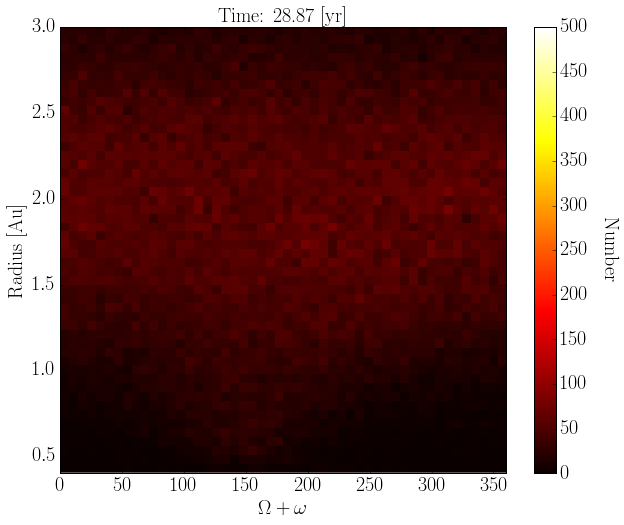

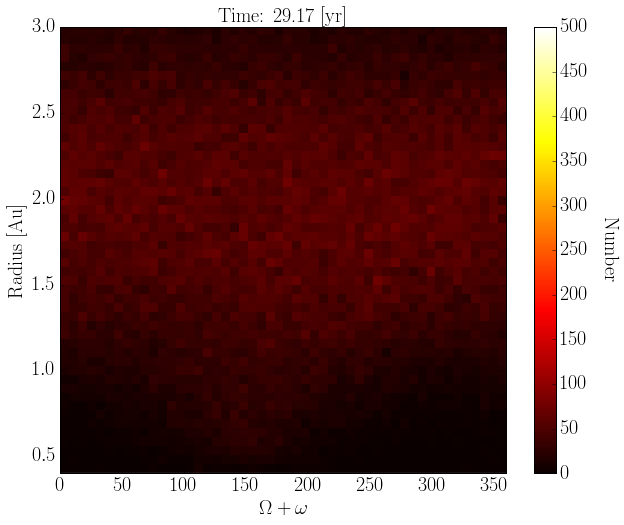

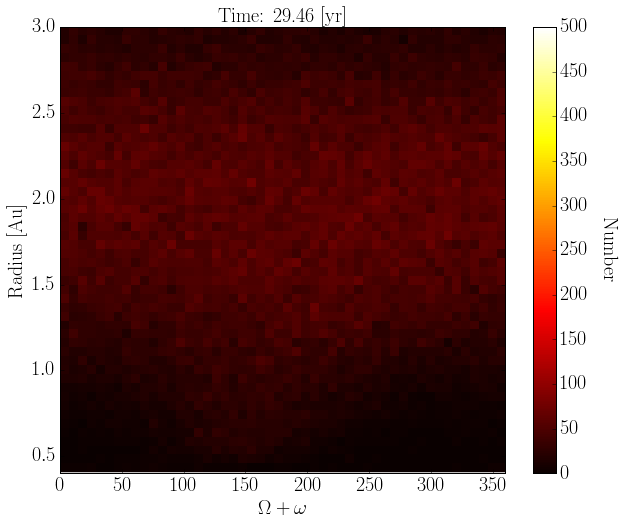

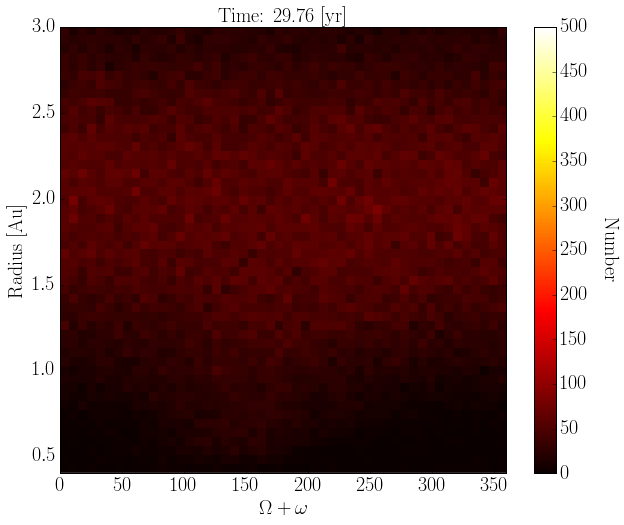

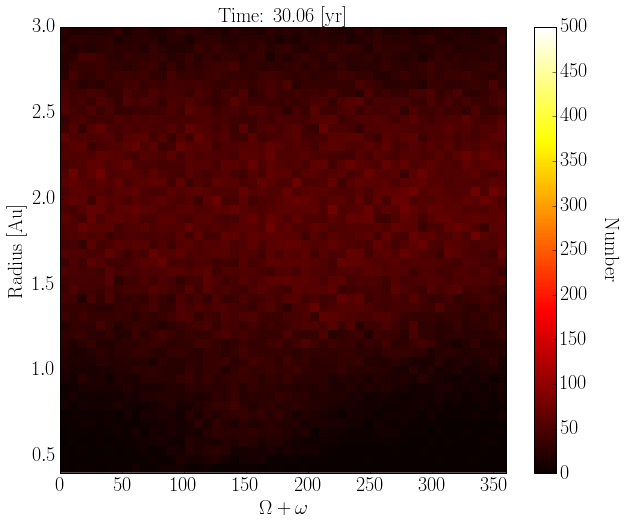

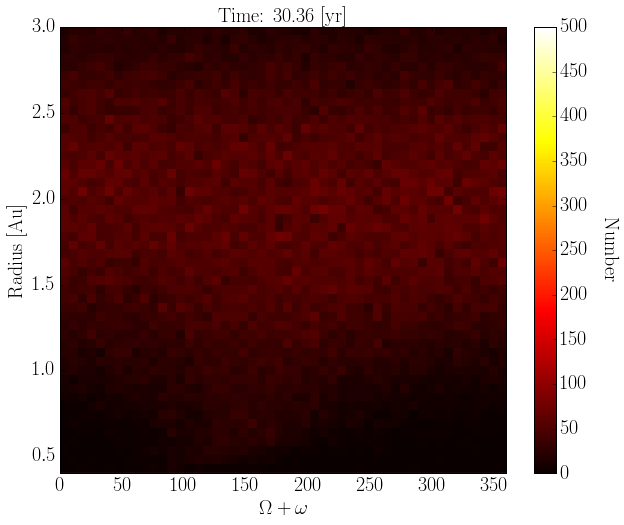

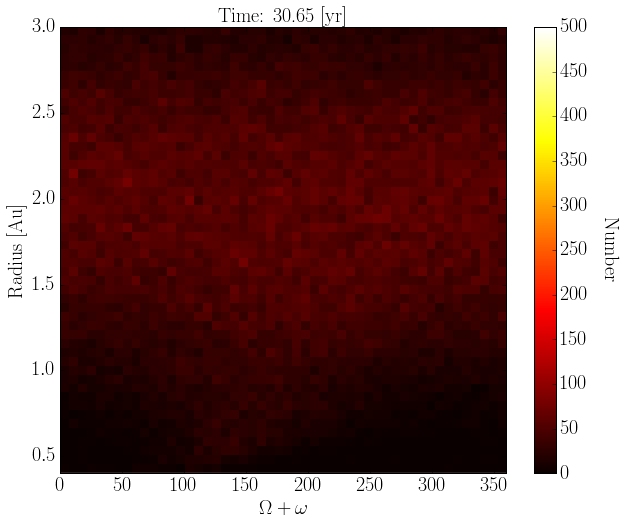

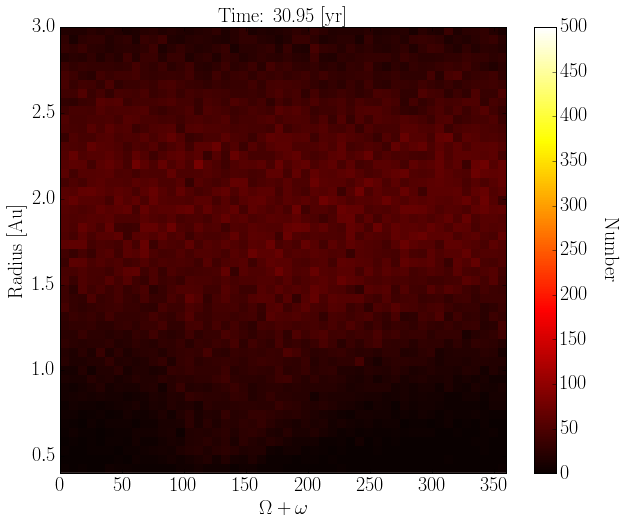

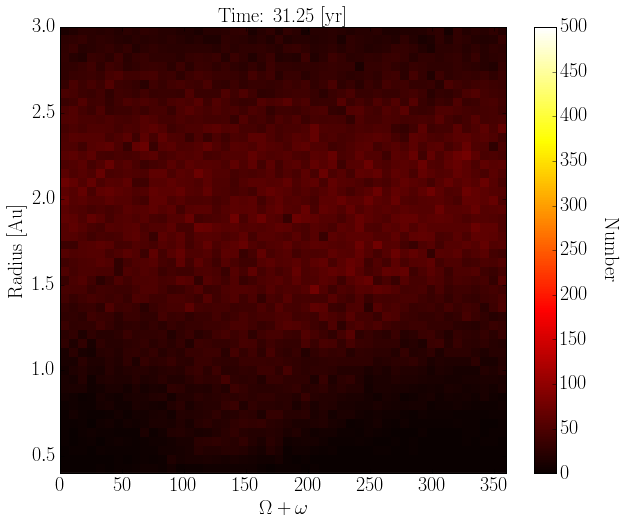

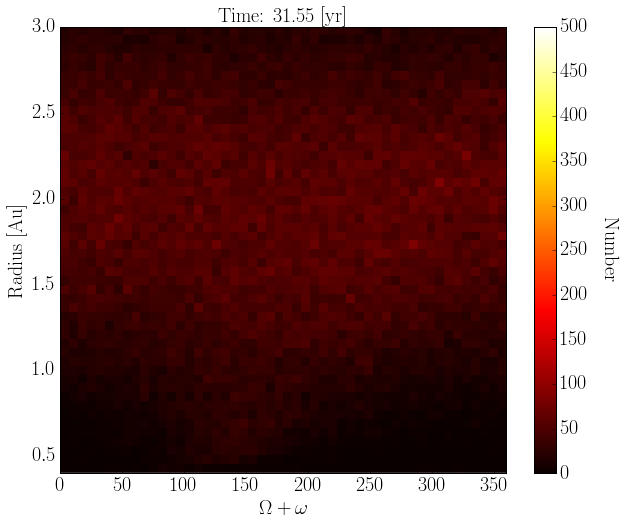

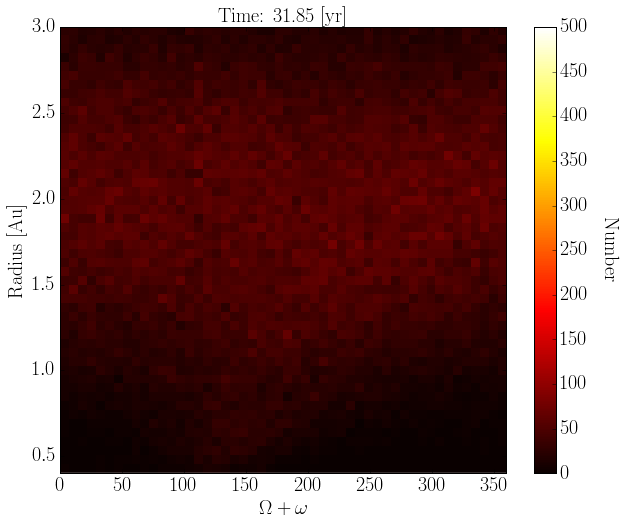

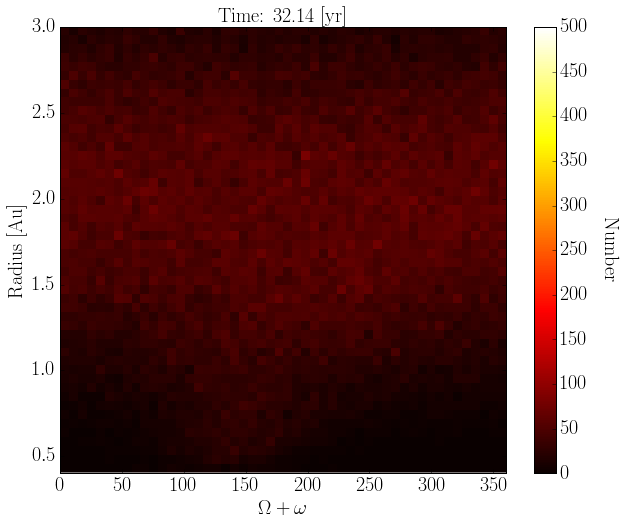

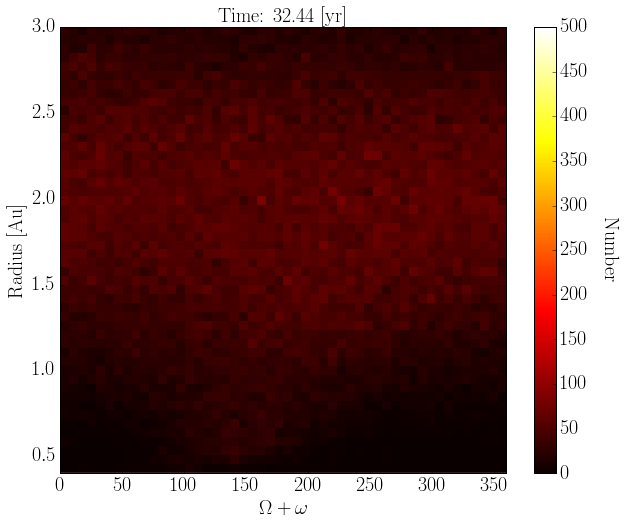

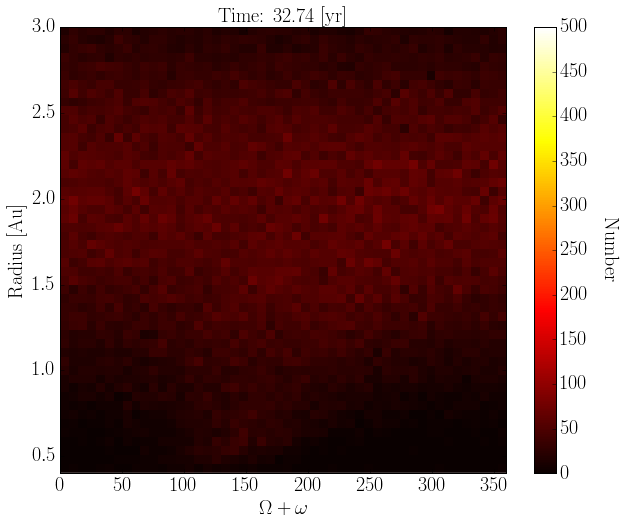

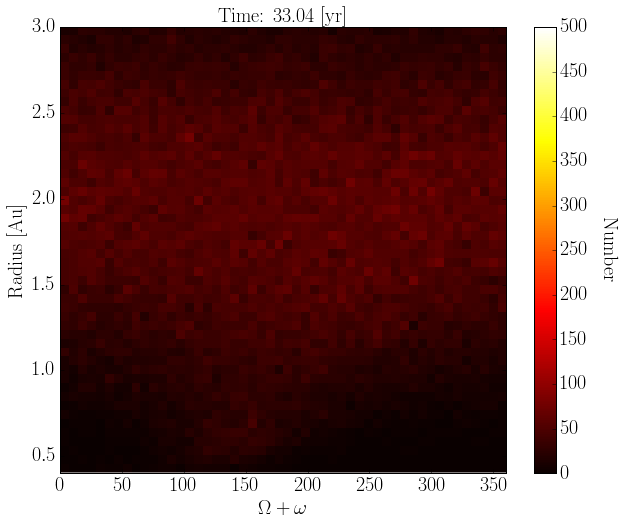

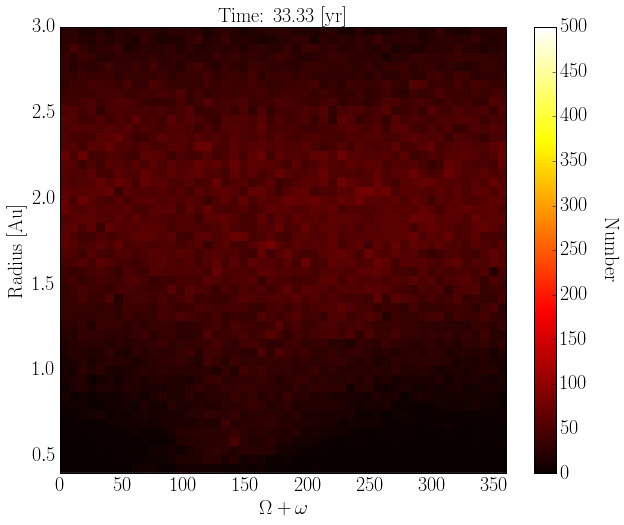

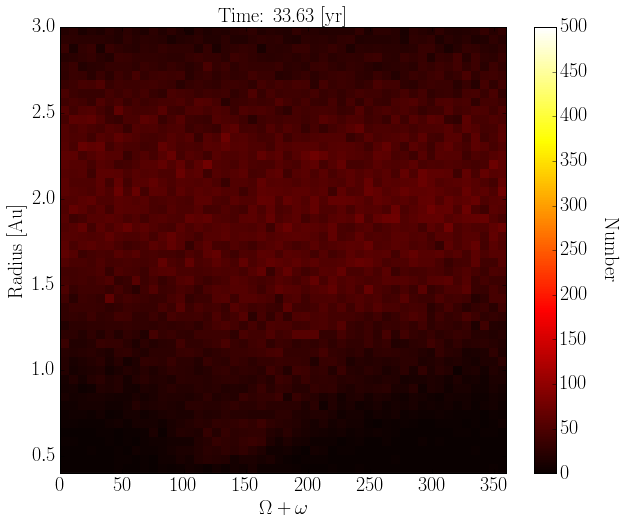

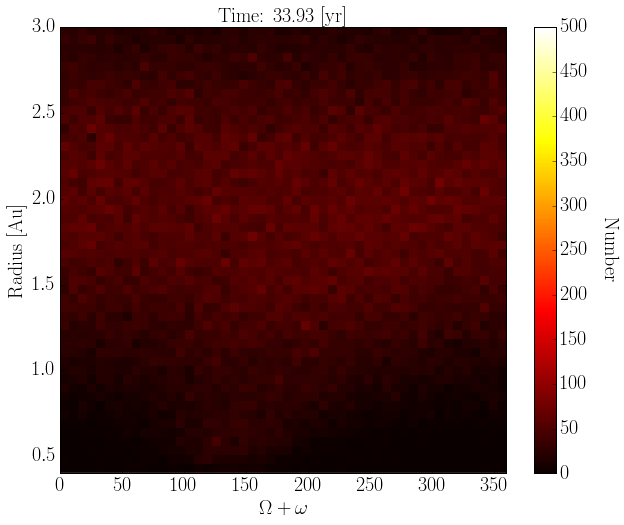

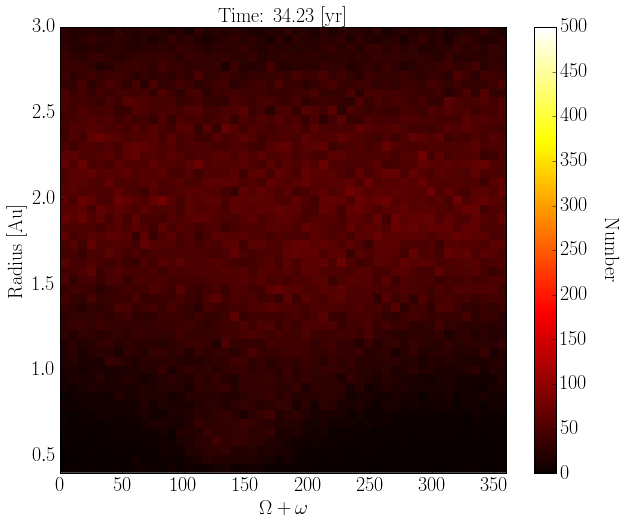

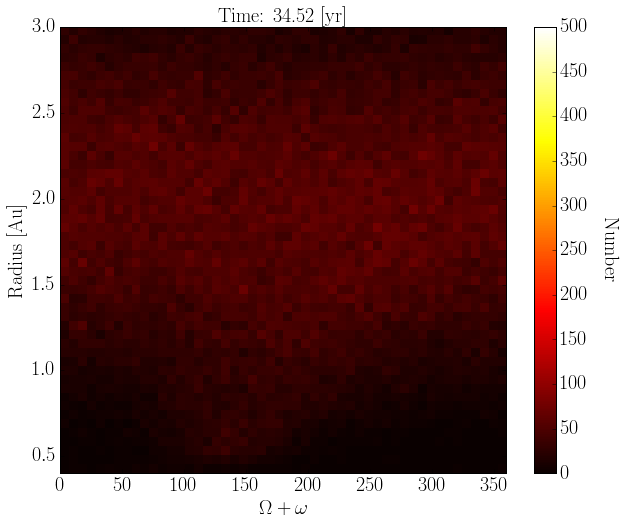

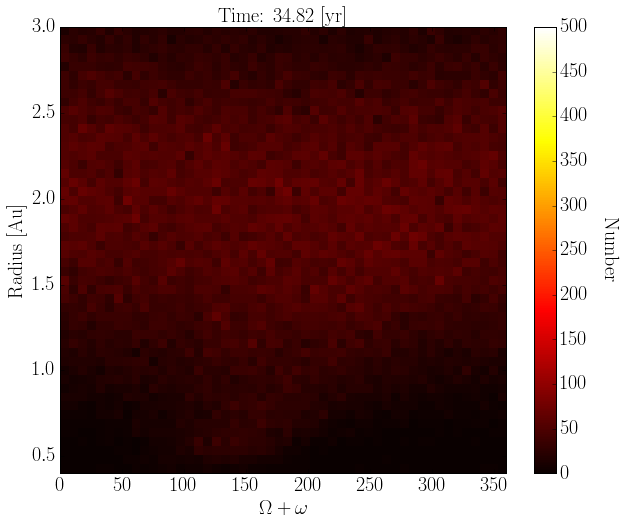

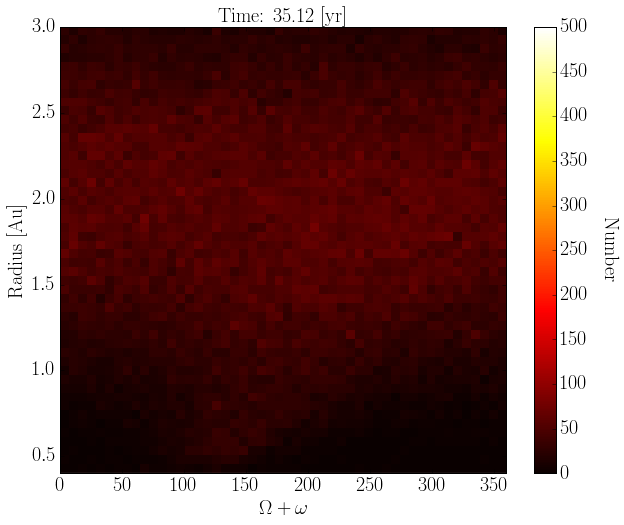

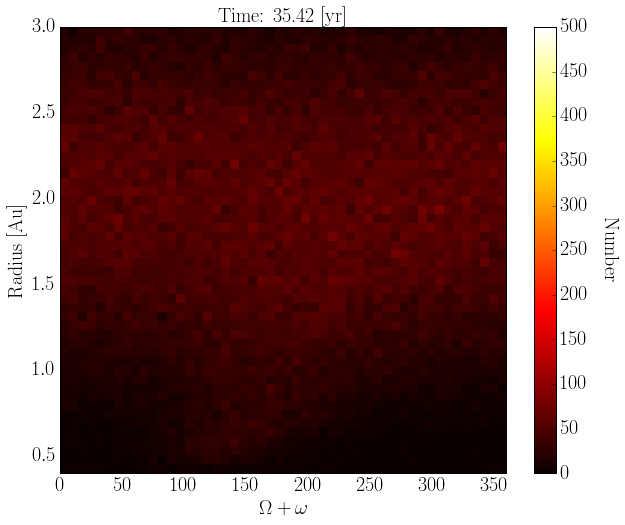

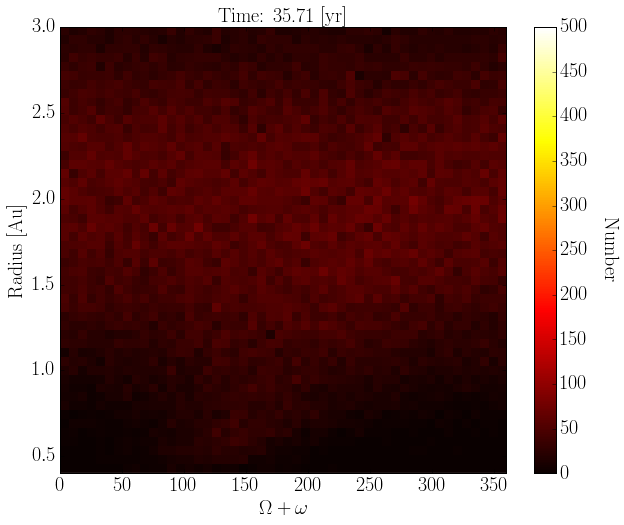

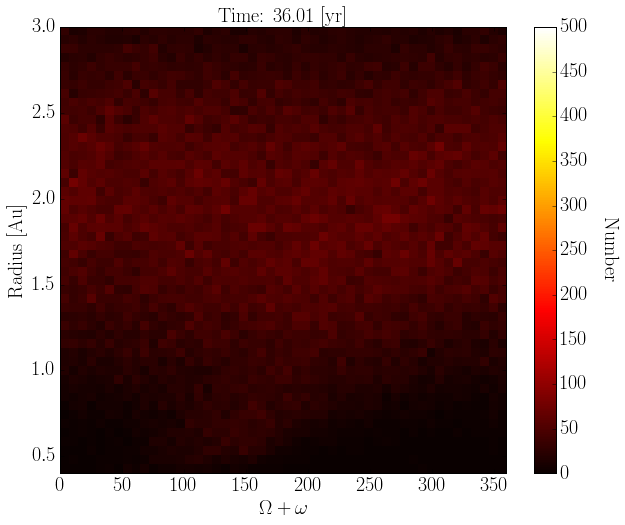

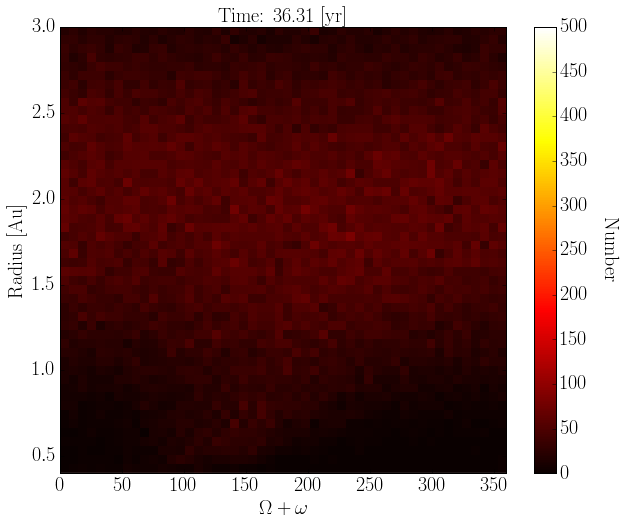

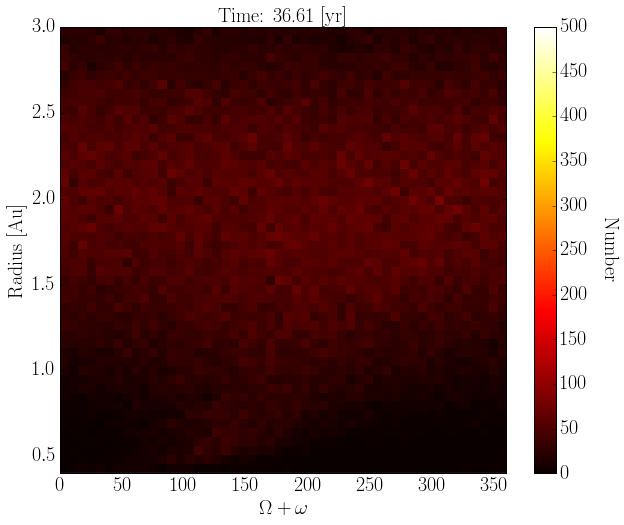

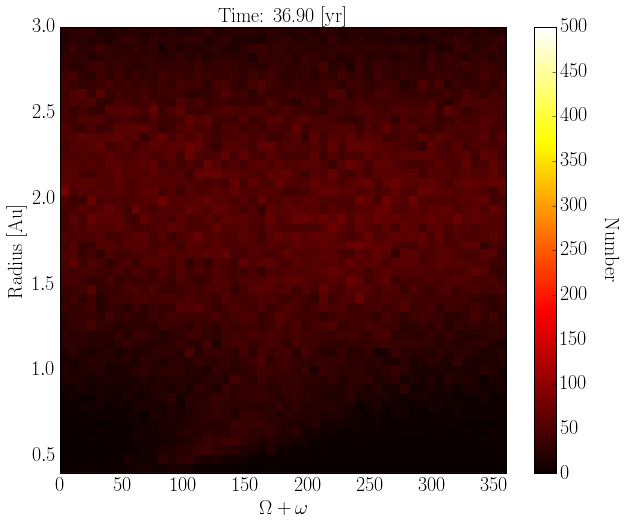

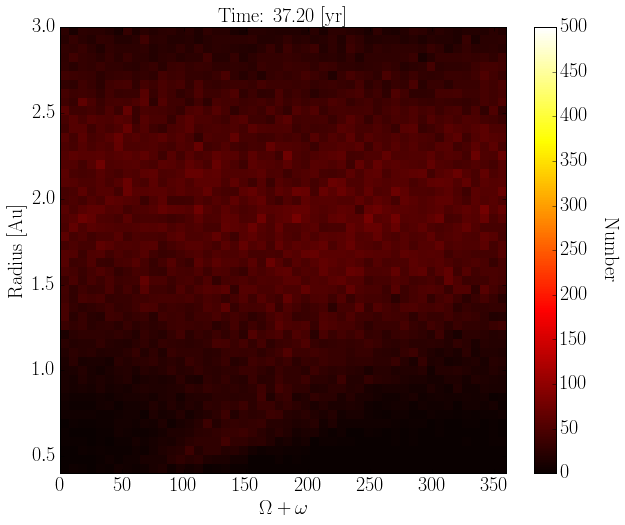

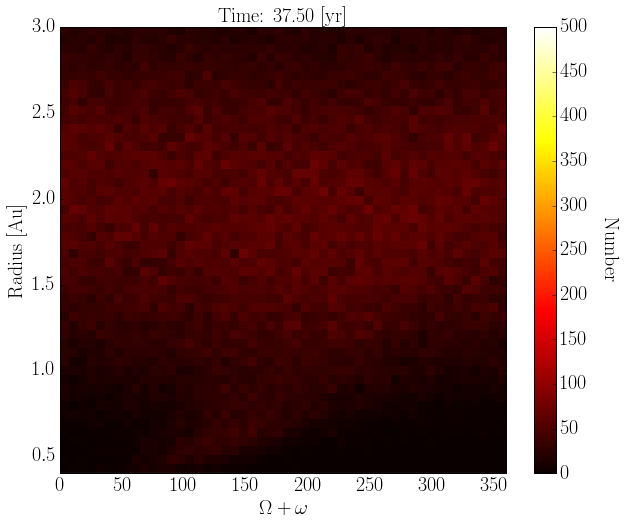

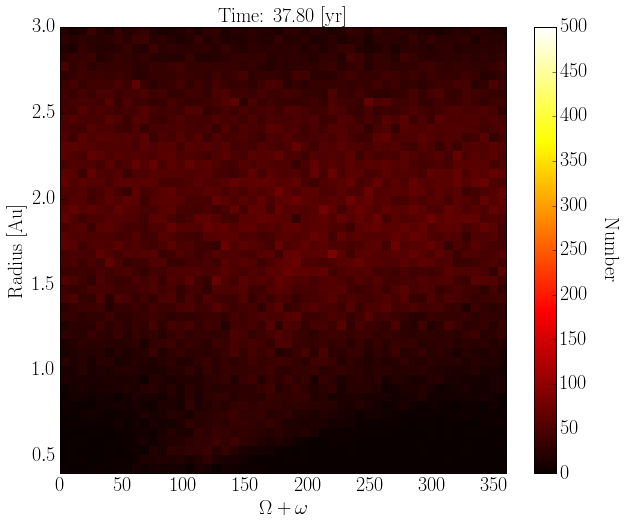

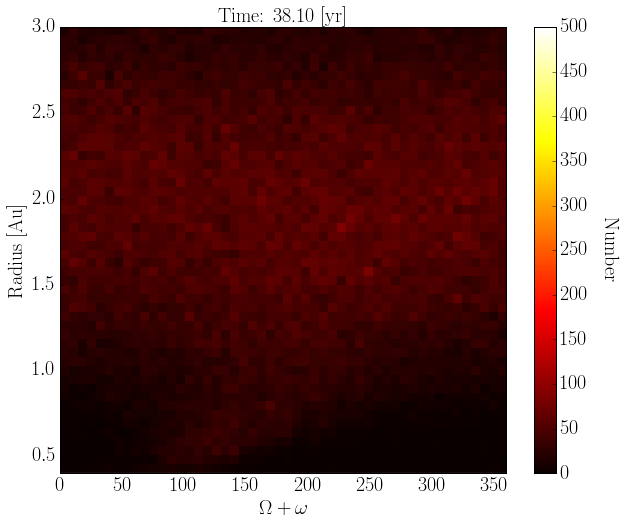

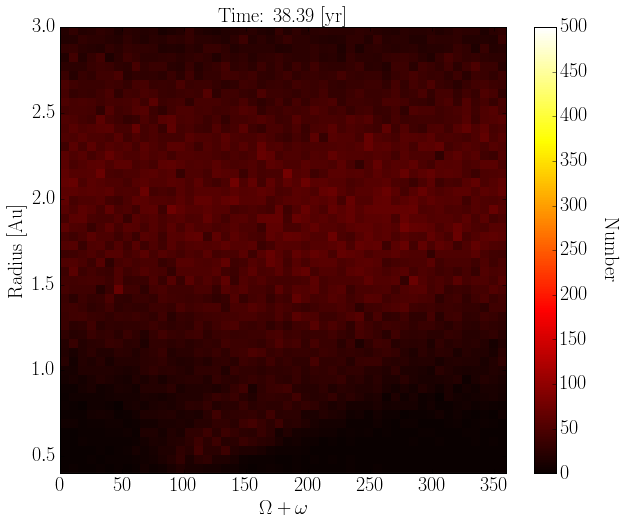

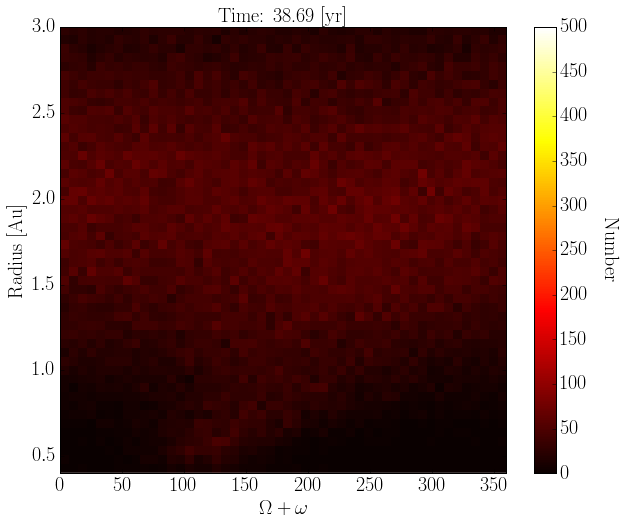

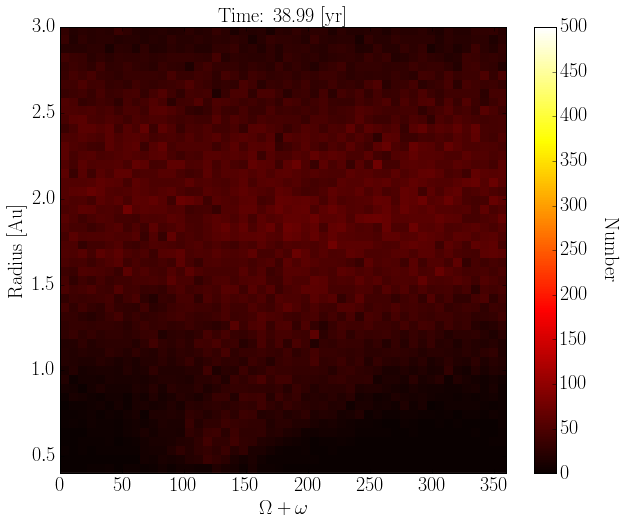

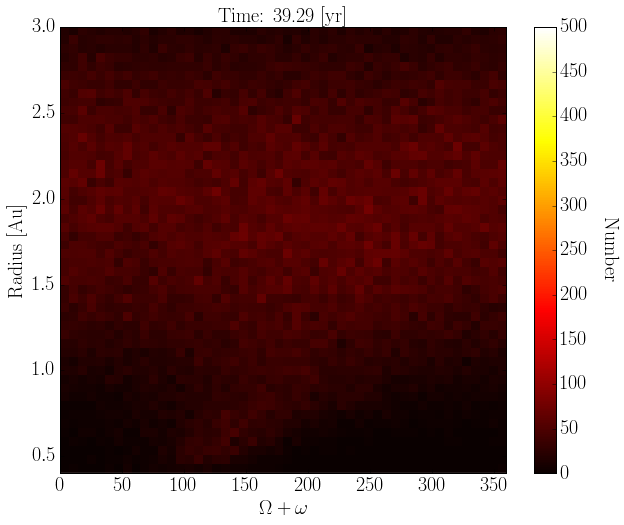

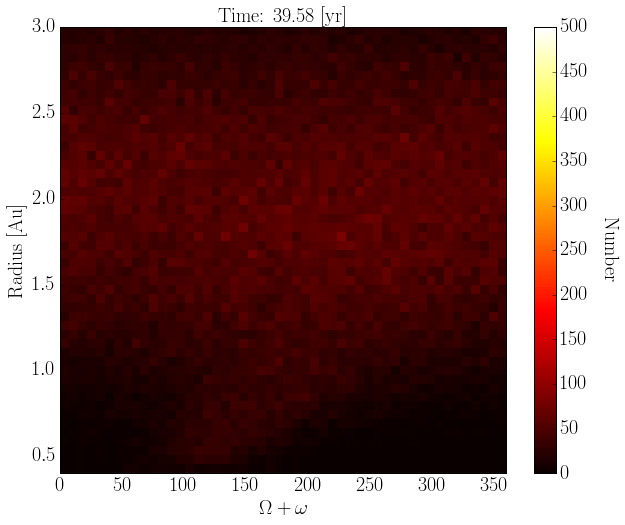

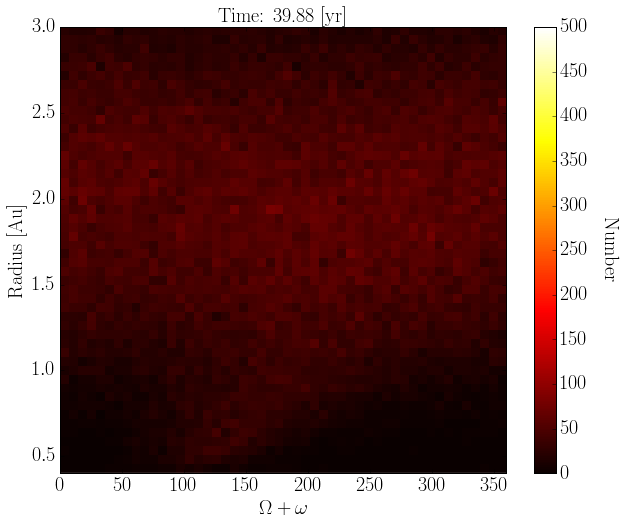

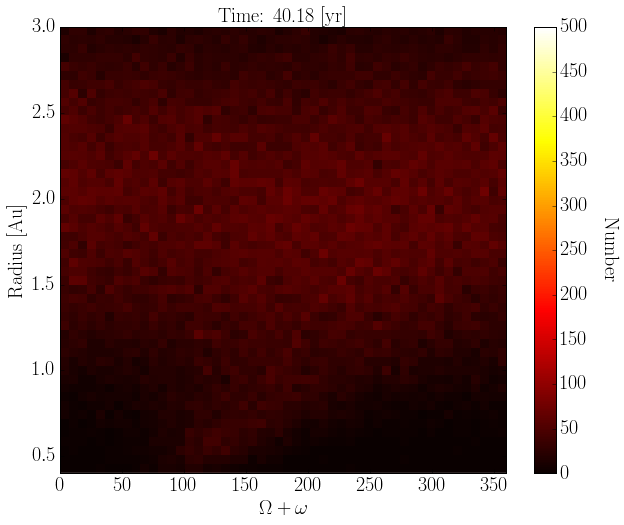

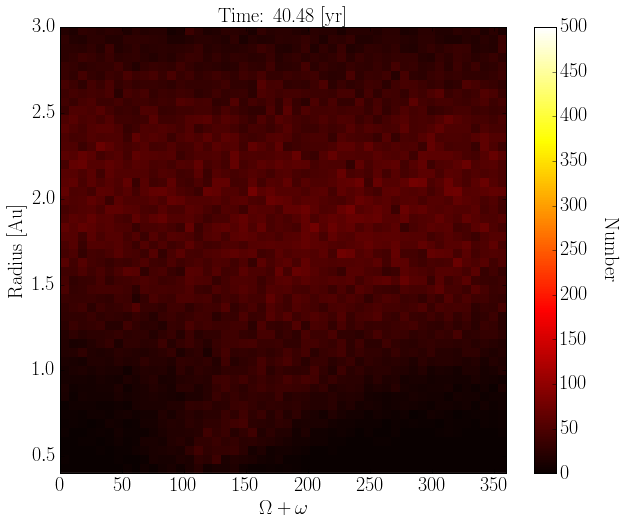

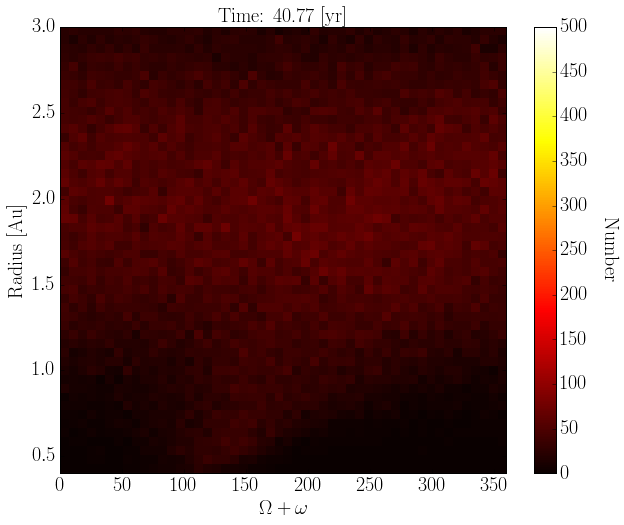

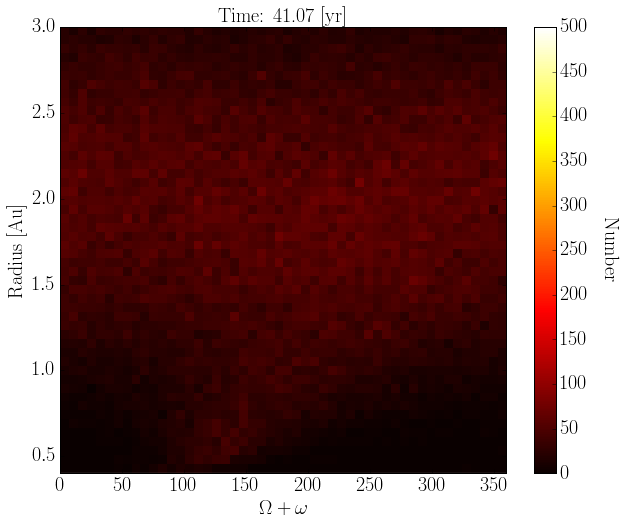

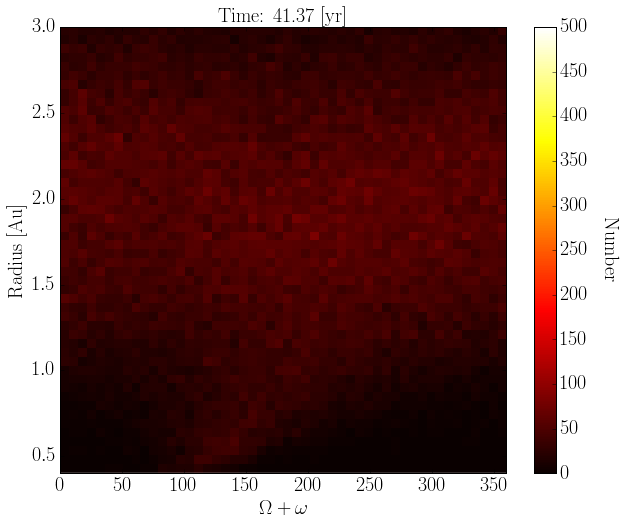

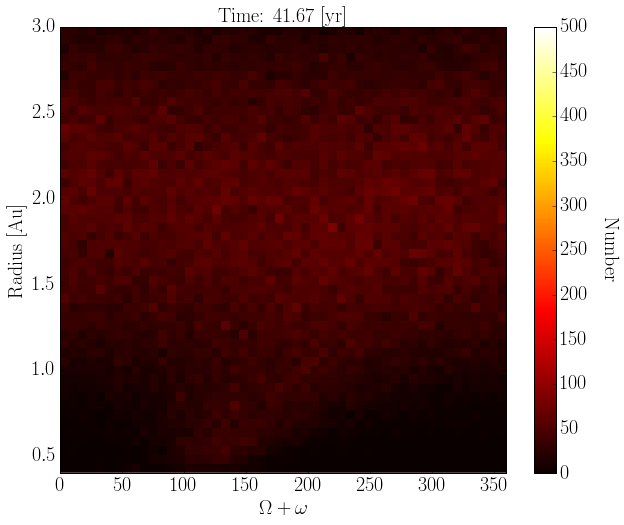

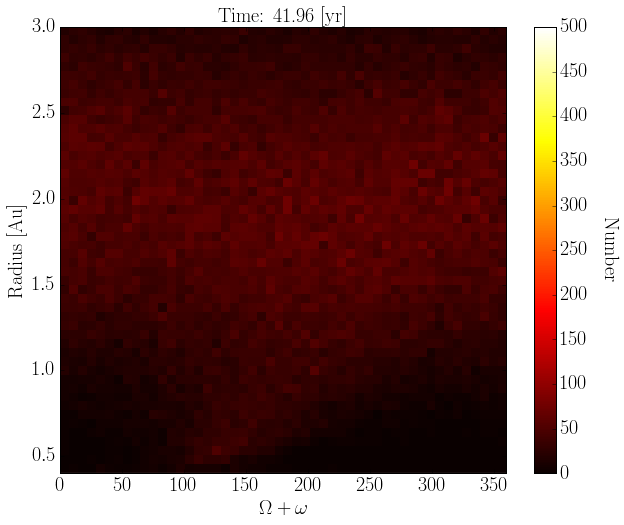

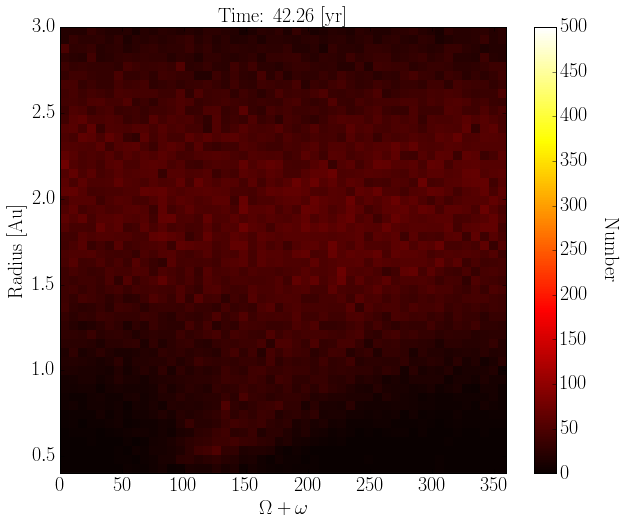

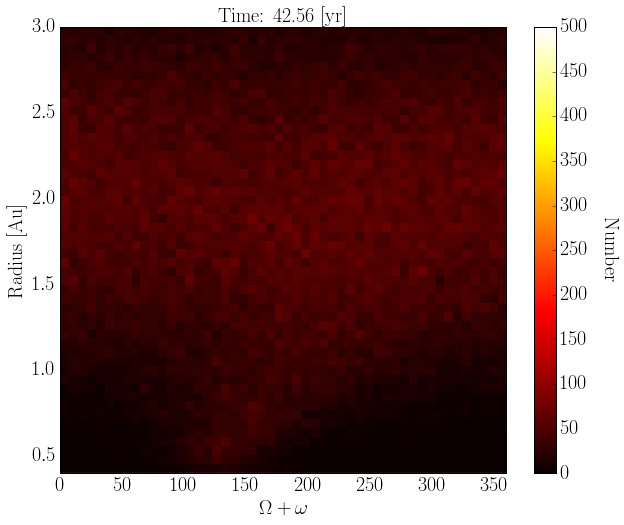

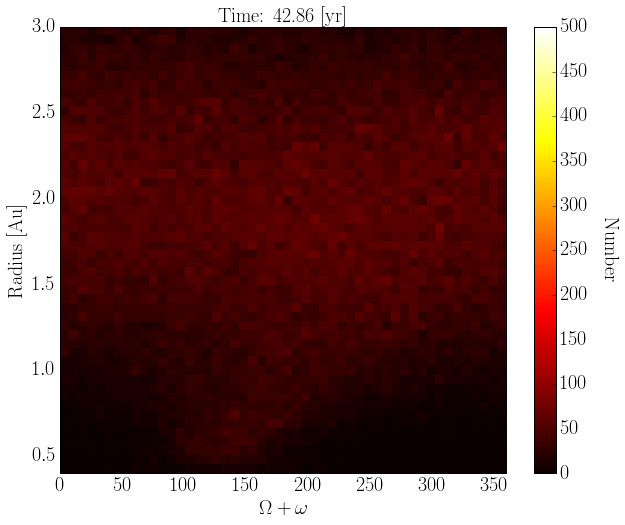

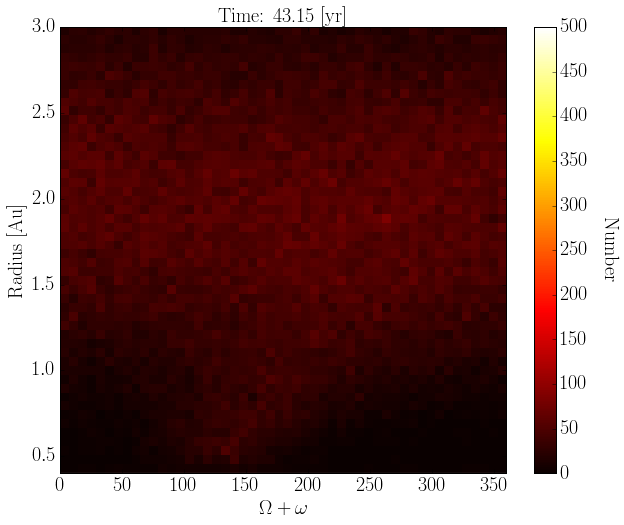

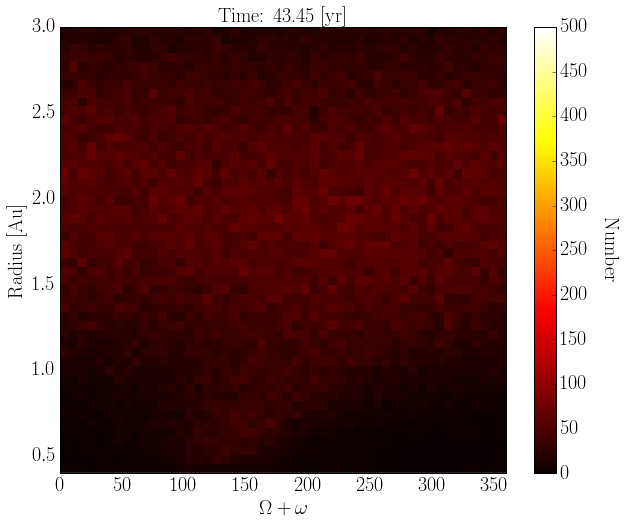

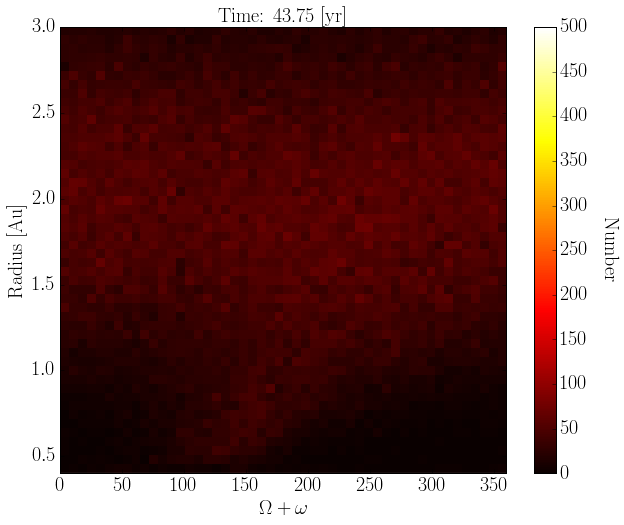

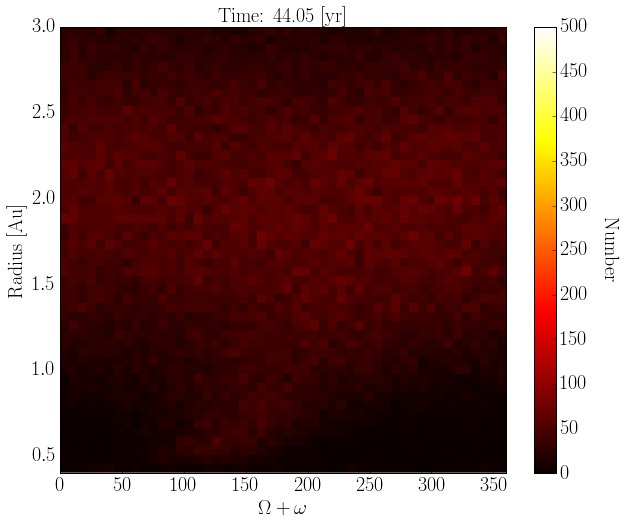

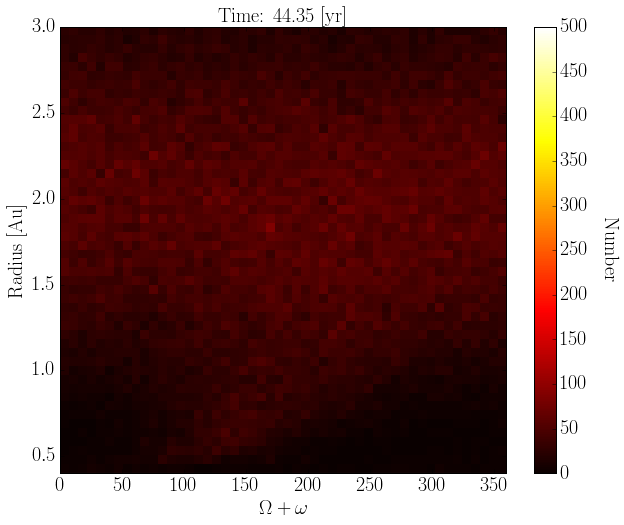

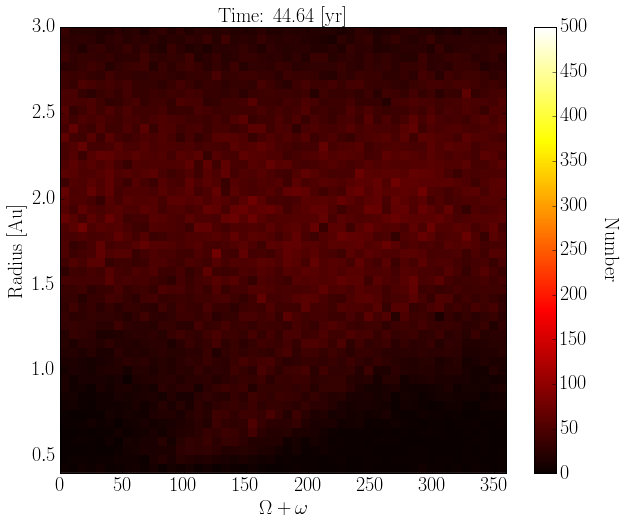

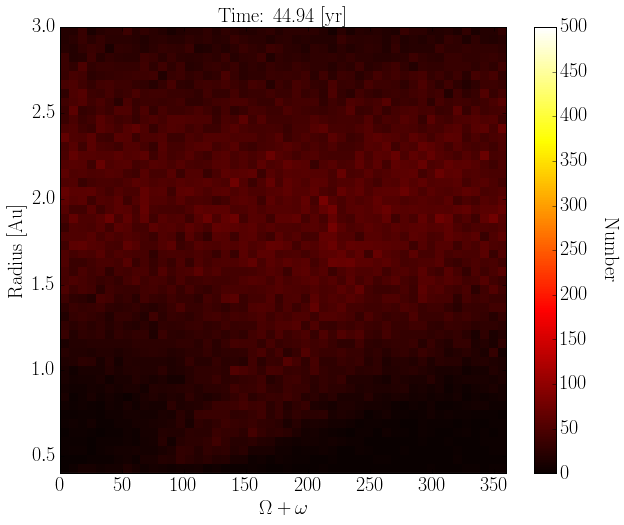

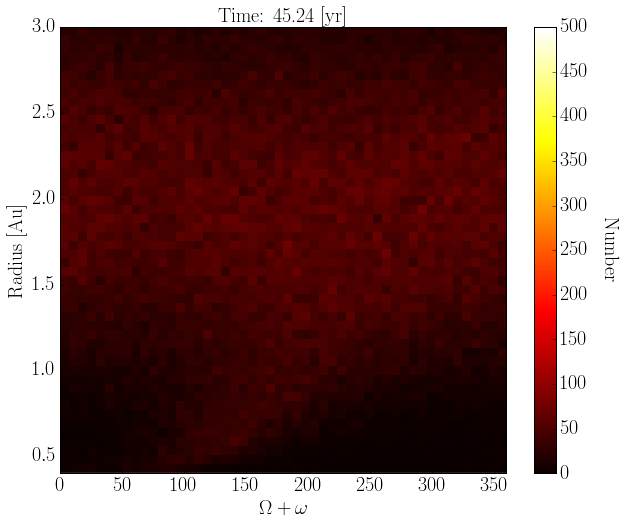

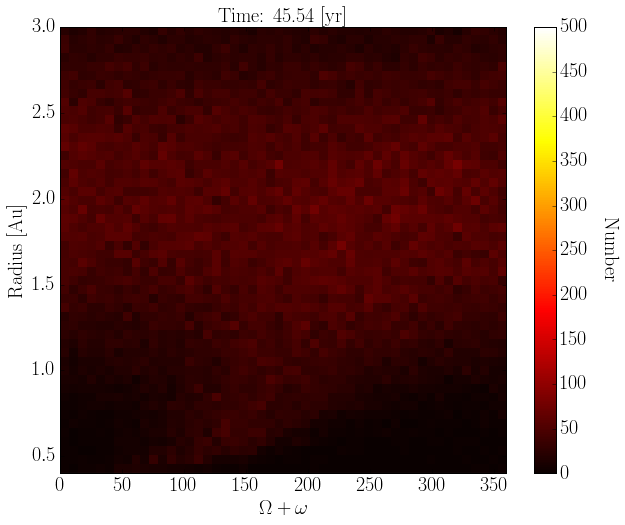

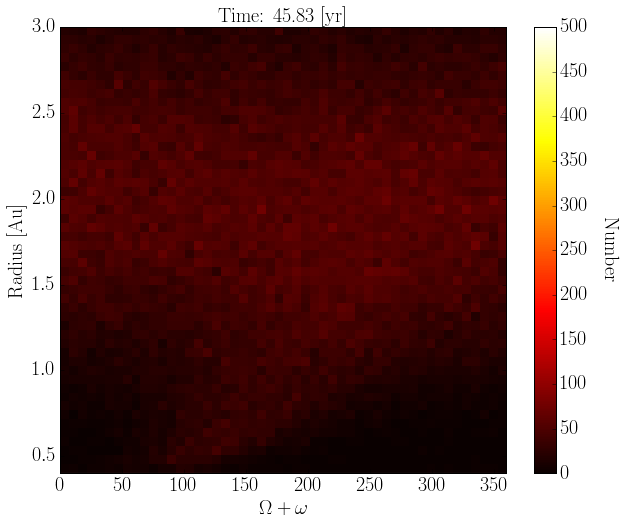

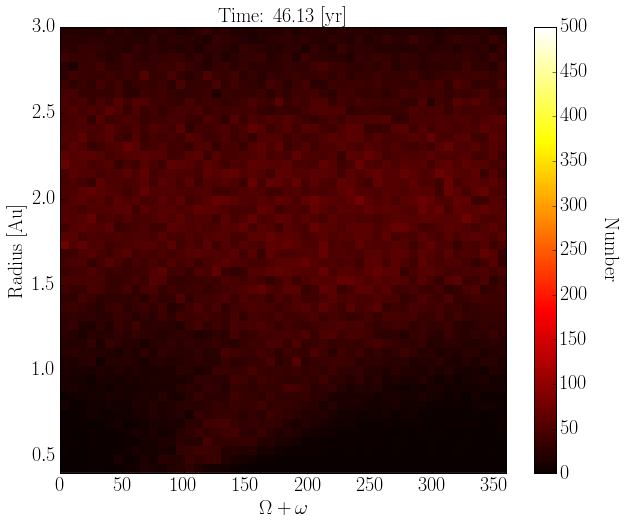

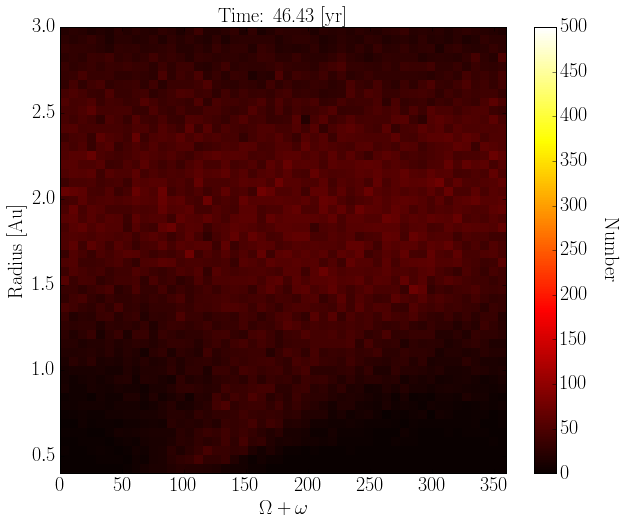

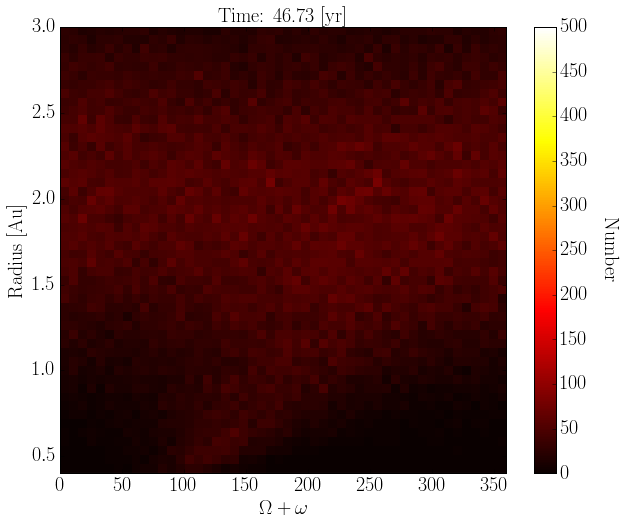

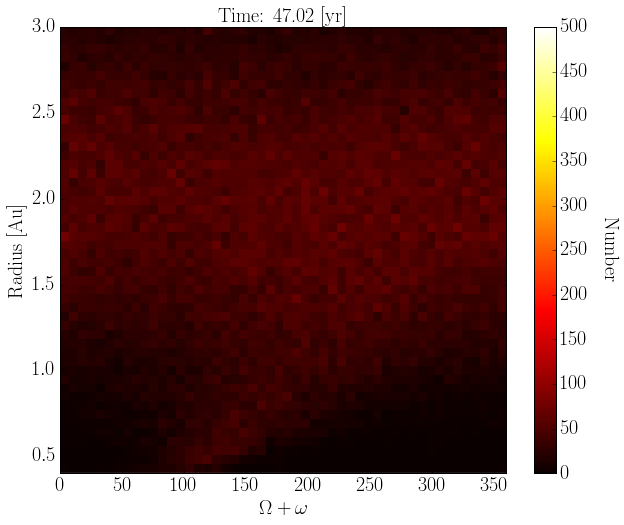

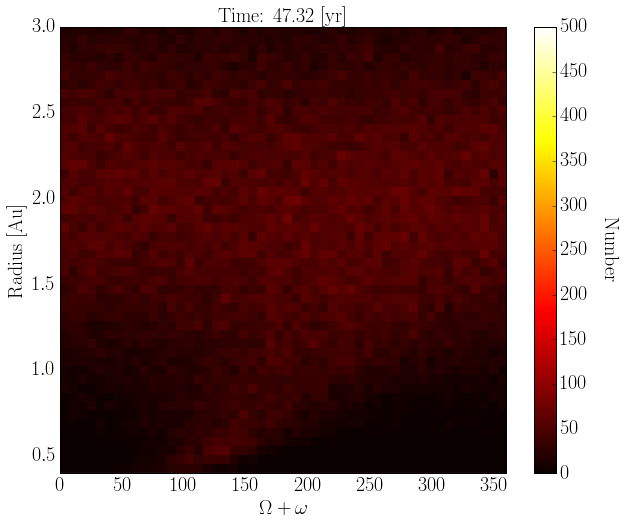

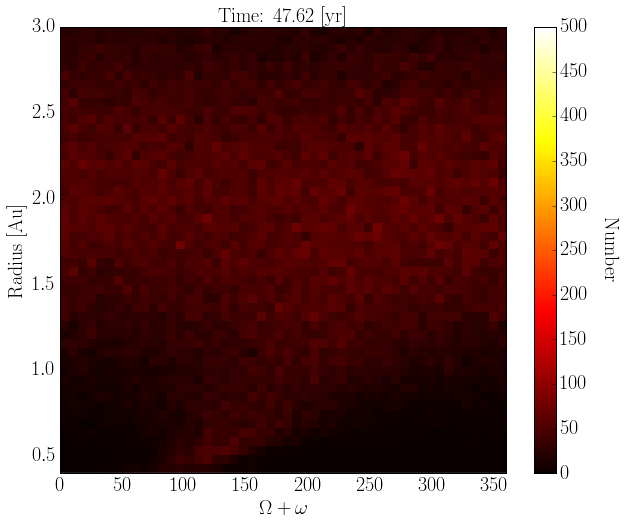

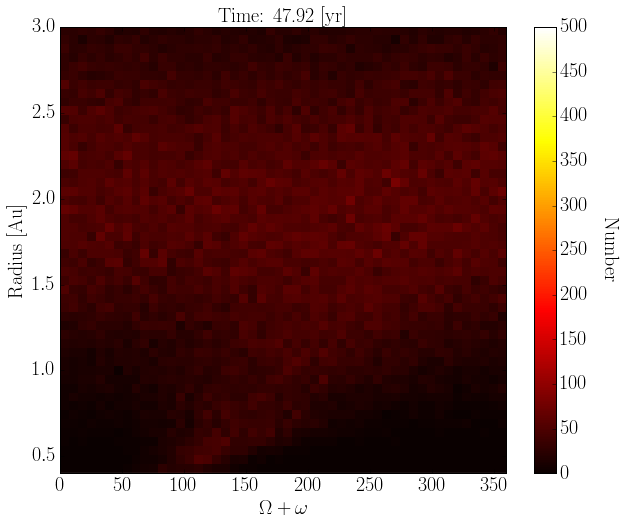

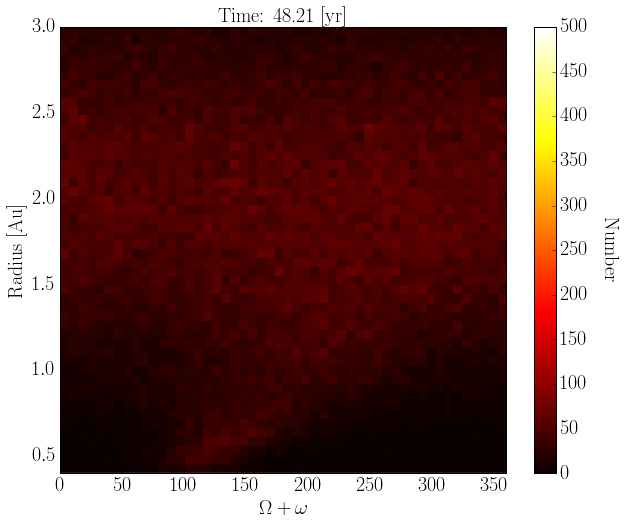

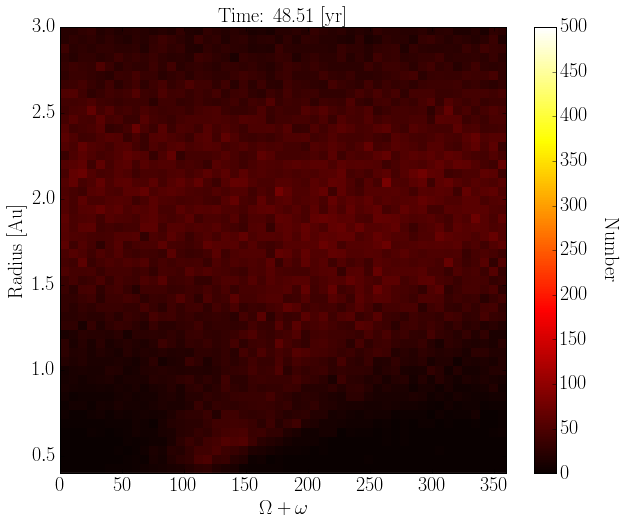

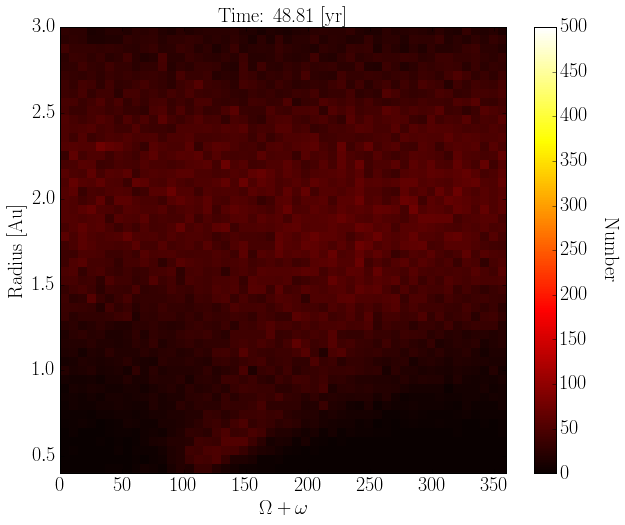

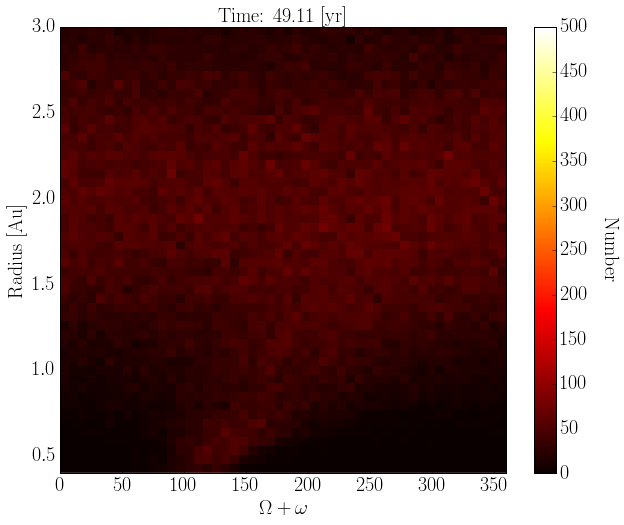

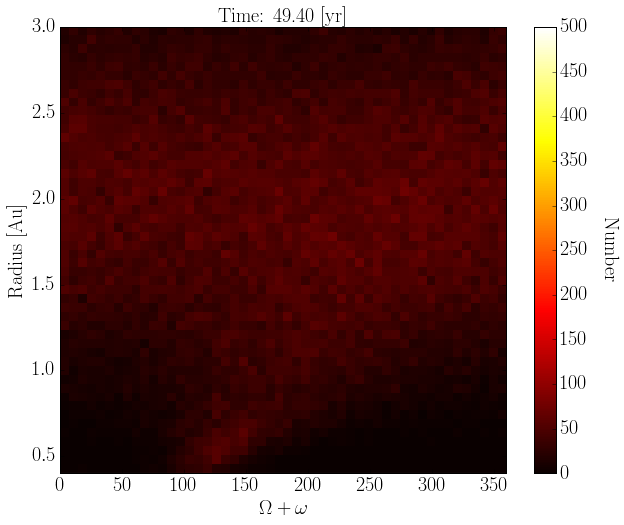

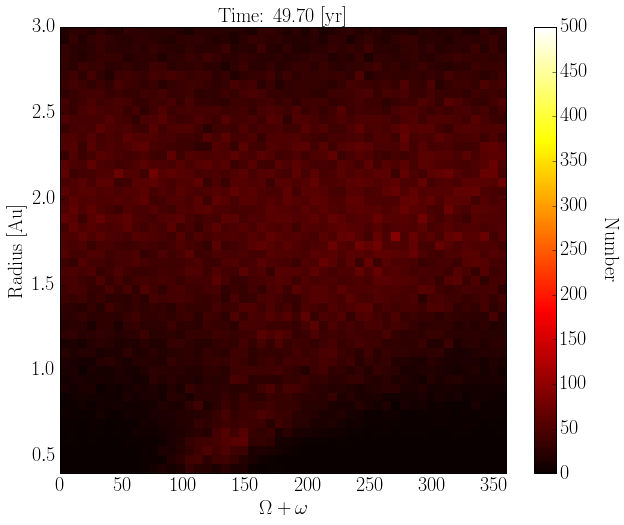

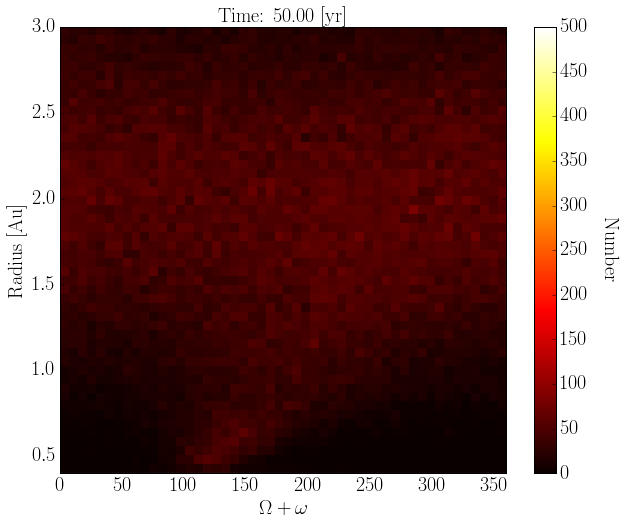

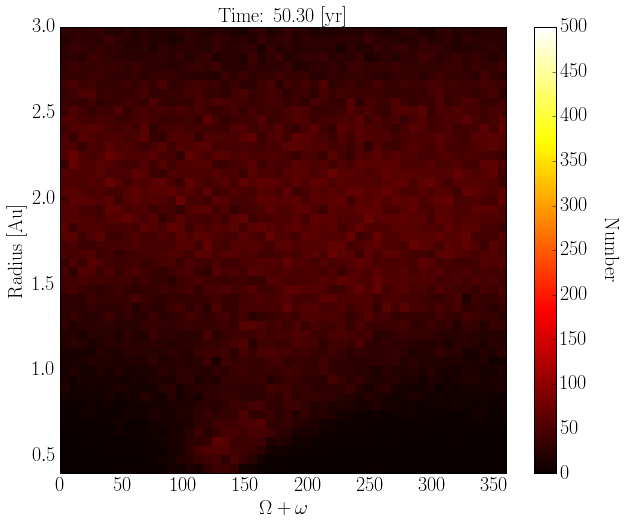

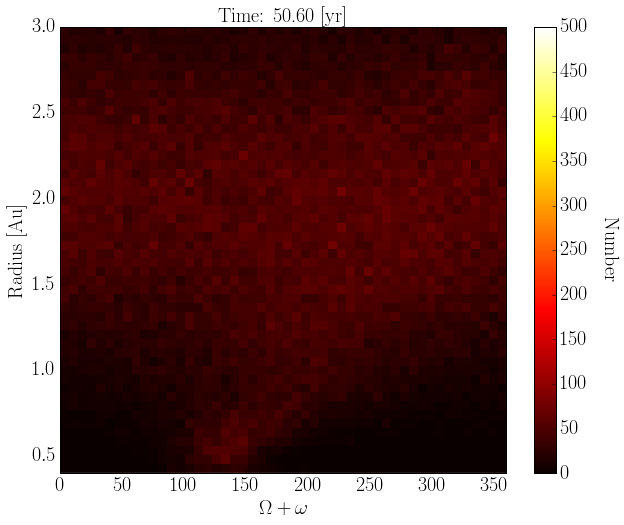

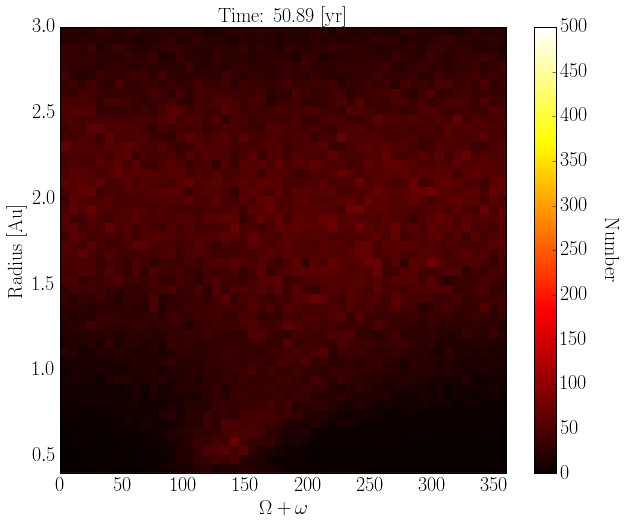

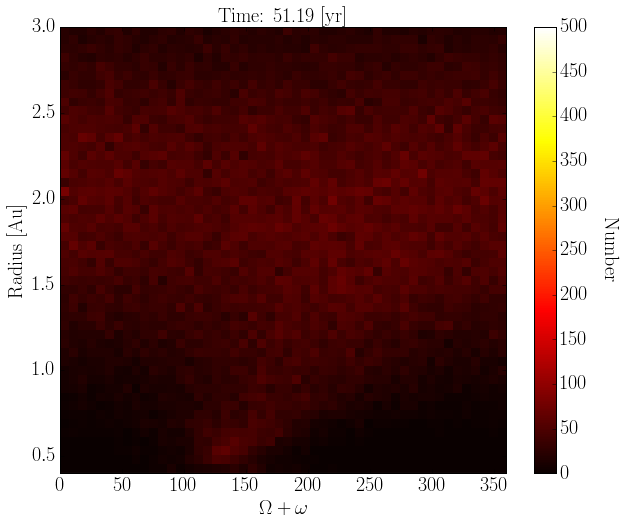

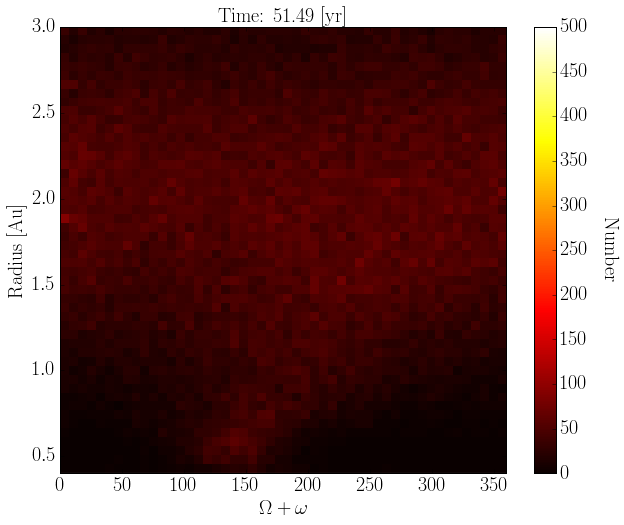

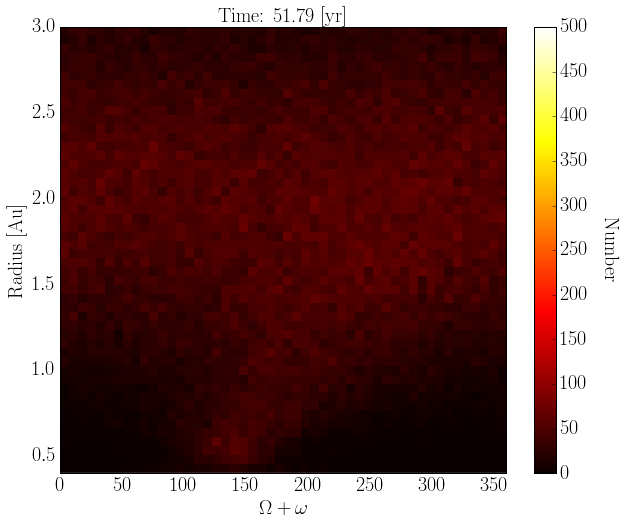

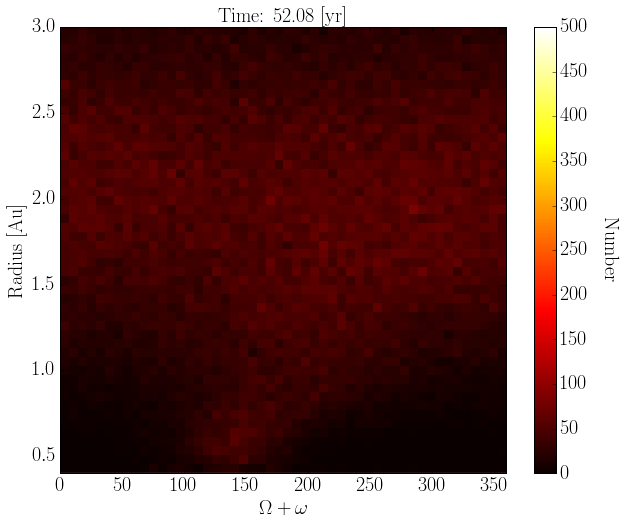

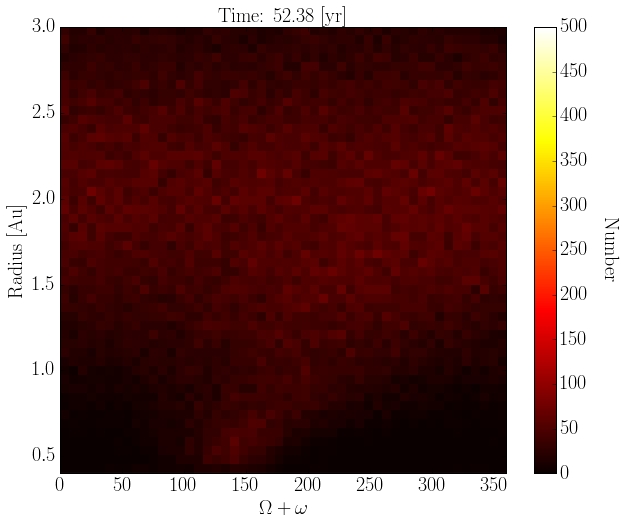

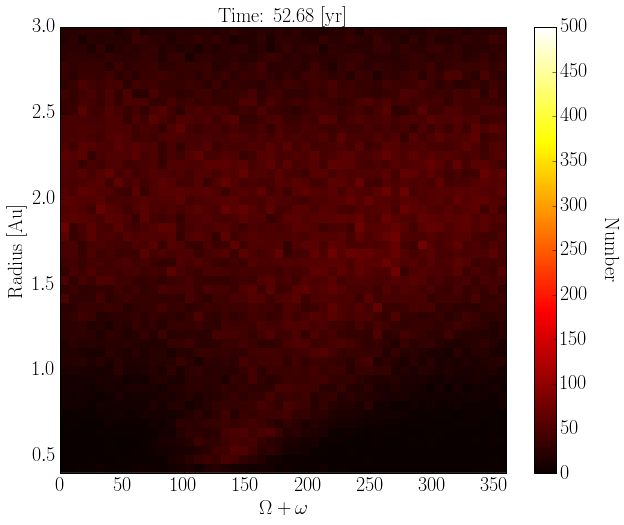

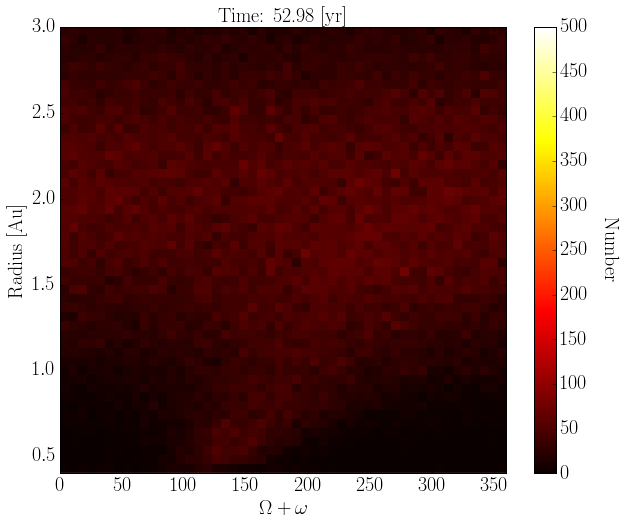

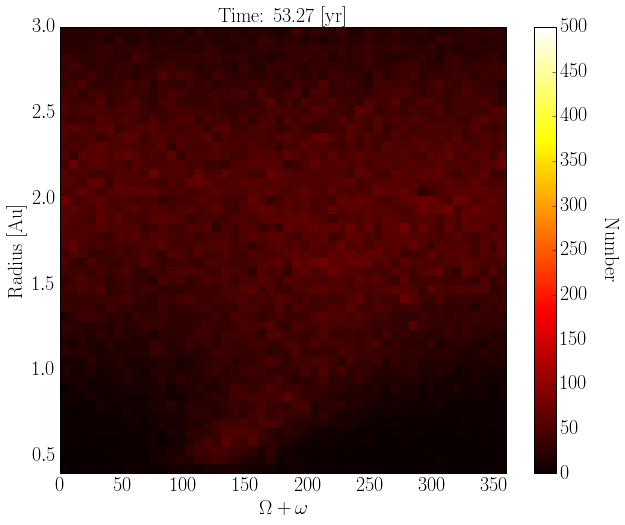

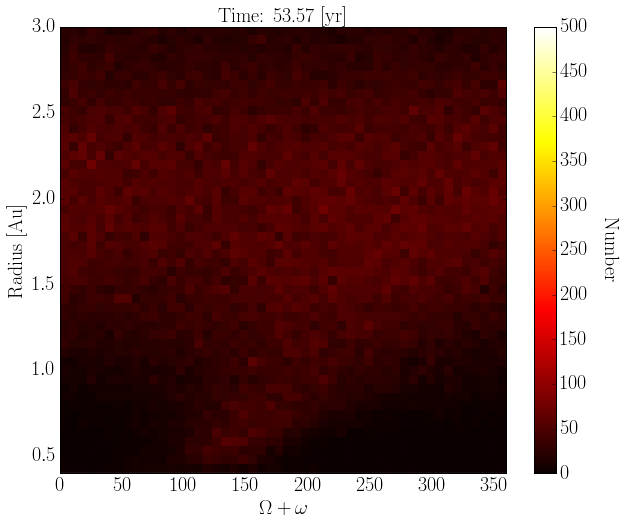

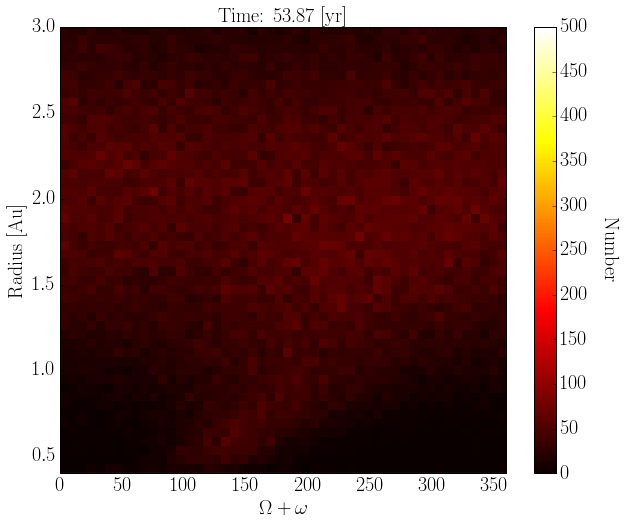

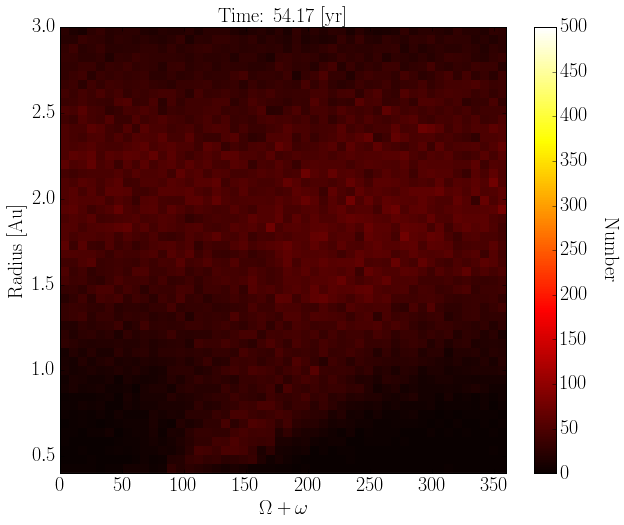

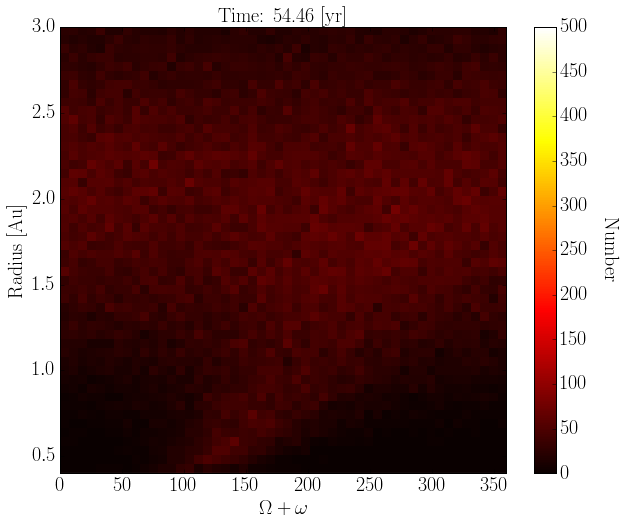

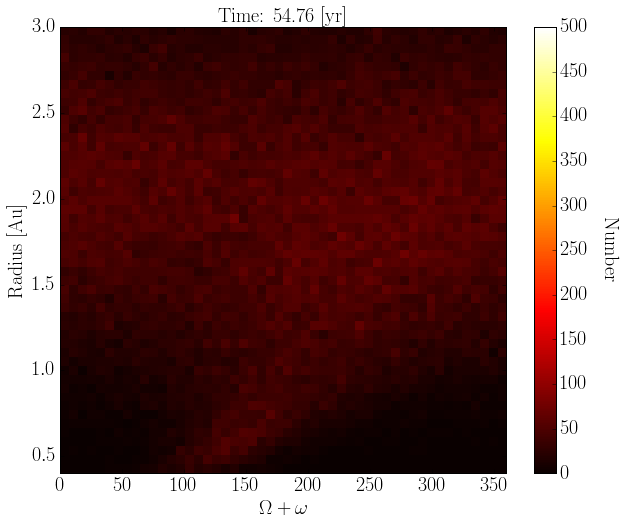

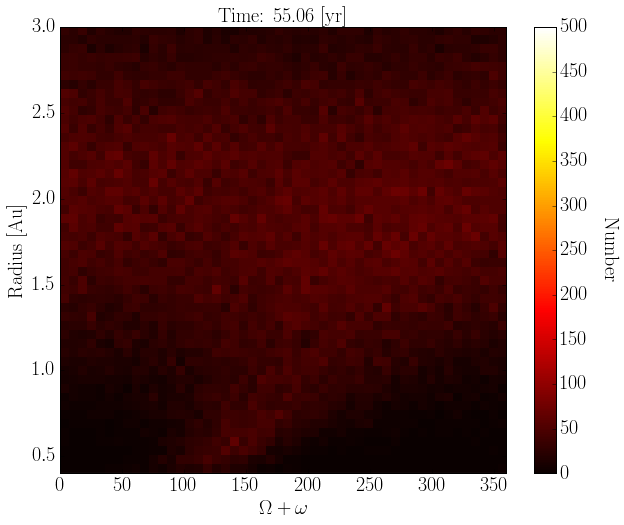

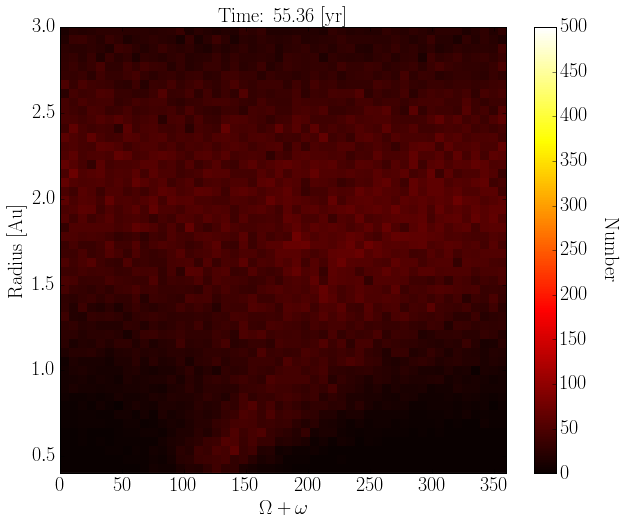

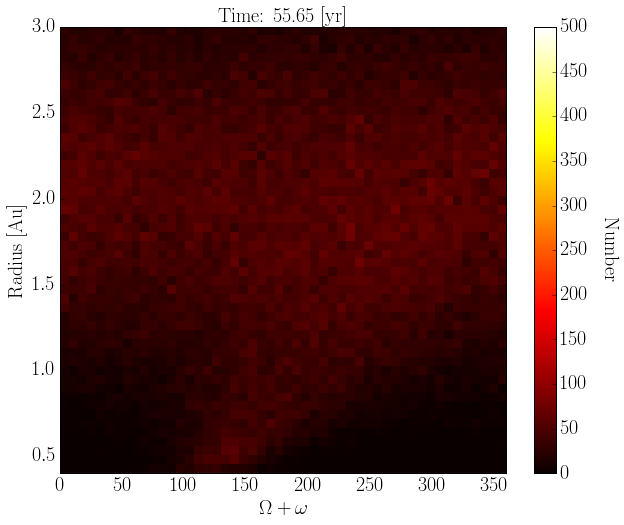

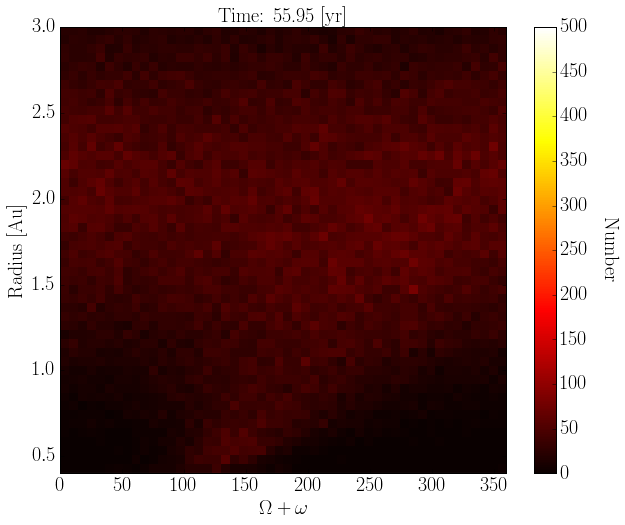

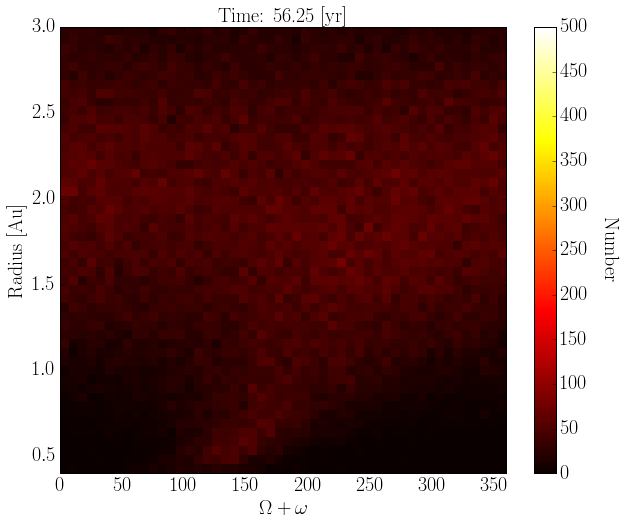

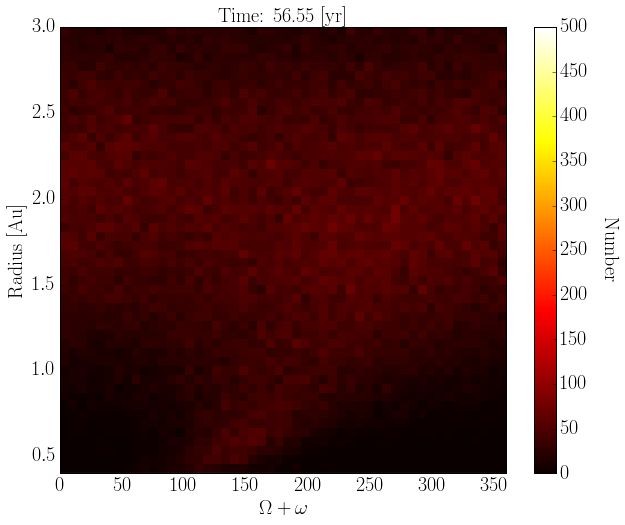

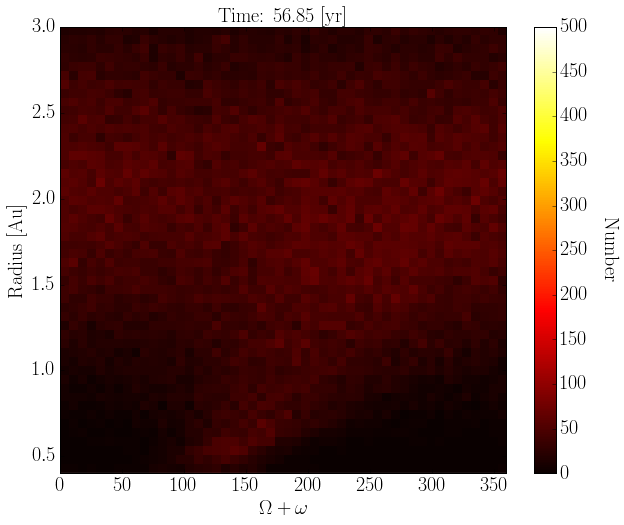

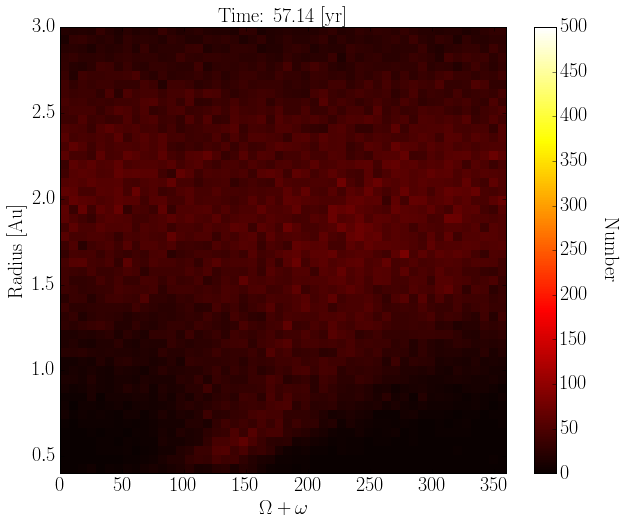

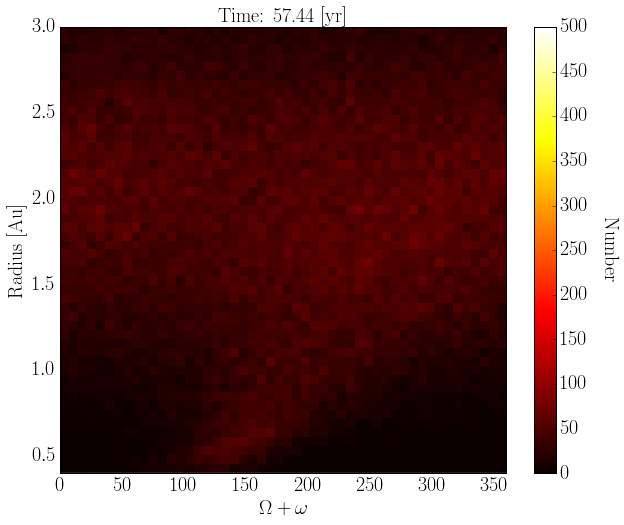

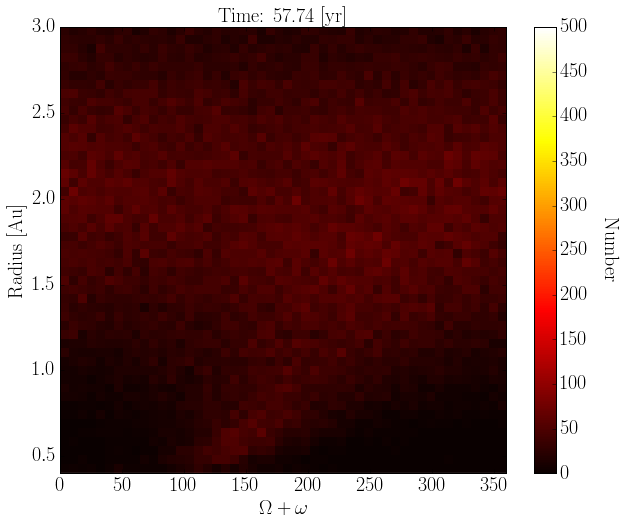

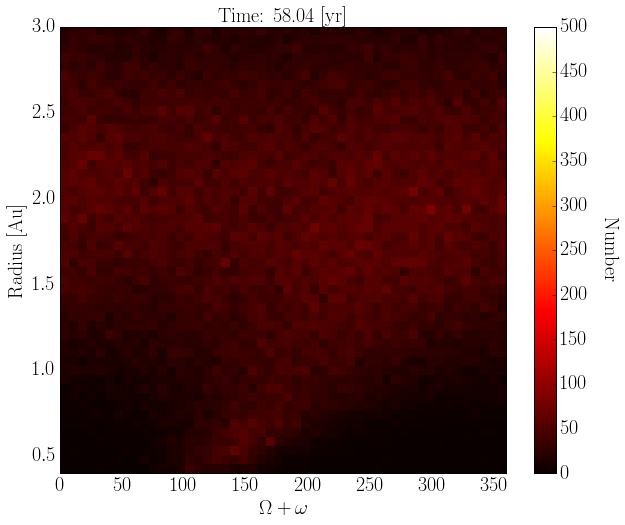

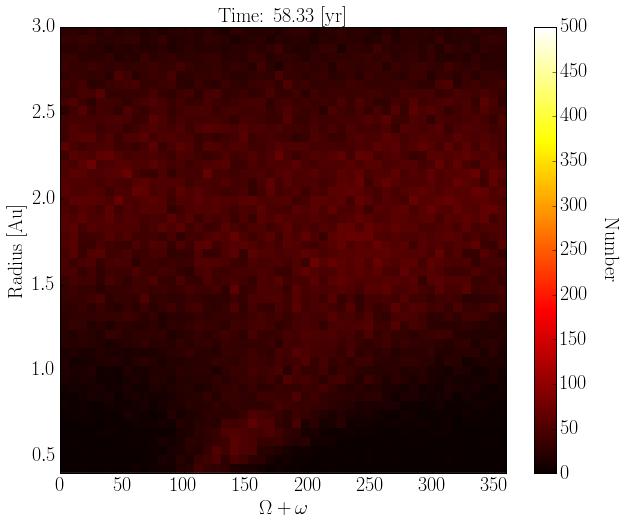

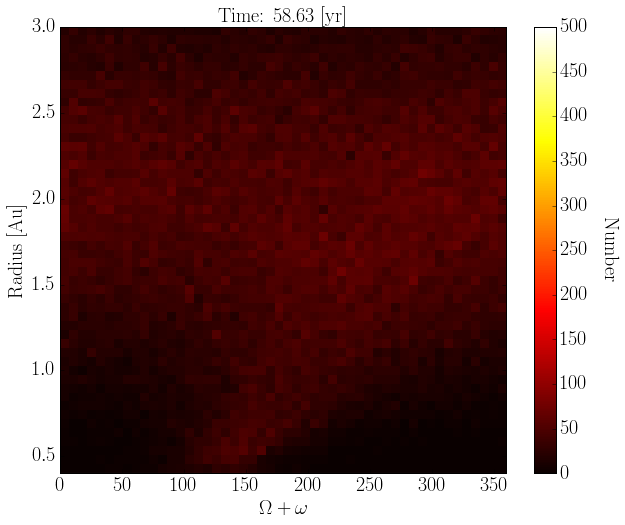

In [7]:
%%capture #So your screen doesn't fill up with pynbody telling you things loaded
for i in range(1,length):
    suffix = str(i*outInt).zfill(6)
    snap_name = name + "." + suffix
    s = pynbody.load(snap_name)
    
    #Center on barycenter
    diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
    s['pos'] -= diskCom
    
    x1_gas = s.gas['pos']
    x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
    v1_gas = s.gas['vel']
    v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
    m1 = np.sum(s.s['mass'])
    m2 = s.gas['mass']

    cm = binaryUtils.computeCOM(s.stars,s.gas,cutoff=3.0).in_units('au')

    #Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
    gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
    gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
    gas_w = AddBinary.calcArgPeri(x1_gas,cm,v1_gas,v_zero,m1,m2) + AddBinary.calcLongOfAscNode(x1_gas,x_zero,v1_gas,v_zero)
    gas_w = gas_w - (test.Omega + test.w)
    gas_w[gas_w > 360] = gas_w[gas_w > 360] - 360.0
    gas_w[gas_w < 0] = gas_w[gas_w < 0] + 360.0

    #Filter out gas particles that aren't bound
    mask = np.logical_and(gas_e < 1,gas_e > 0)
    gas_a = gas_a[mask]
    gas_w = gas_w[mask]
    gas_e = gas_e[mask]

    #Now Filter gas particles to within a certain distance
    mask = np.logical_and(gas_a < 3,gas_a > 0.4)
    gas_a = gas_a[mask]
    gas_w = gas_w[mask]
    gas_e = gas_e[mask]

    #Plot heatmap
    fig, ax, im, cbar = diskplot.plot_heatmap(gas_w,gas_a,labels=['$\Omega + \omega$','Radius [Au]','Number'],
                                    cm='hot',vmin=0,vmax=500)
    ax.set_ylim(0.4,3)
    ax.set_xlim(0,360)
    ax.set_title("Time: %.2lf [yr]" % (dt*i*outInt))
    
    #Save fig for future movie
    fig_name = "k38WvsA." + str(i) + ".png"
    fig.savefig(fig_name)